# Penetration of Neutrons Through Shielding

Hardik Kohli<br>
University of Manchester  
May 2022

To begin our analysis, the python interpreter is first initialized.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import display, Markdown
from math import *
import time

#Constants

# Avogadro's Number
NA = 6.0221408 * 10**23 # mol^-1

# Initializing the figure and setting some defaults.

plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["axes.grid"] = False
plt.rcParams["figure.titlesize"] = 20

plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

plt.rcParams["legend.fontsize"] = 16


## 1. Integrating using Monte Carlo Method

For our analysis, we rely on integration. We will do these integrations using the Monte Carlo method, which uses random numbers to perform the same. Given an integral, we can define it as an average,

$$S = \int_{x_1}^{x_2}f(x)dx = (x_2-x_1)<f(x)>$$

which can be written as,

$$S \approx (x_2-x_1)\frac{1}{N}\sum_{i=1}^Nf(x_i)$$

and can thus be written as an algorithm given as,

$$x_i = (x_2-x_1)u_i + x_1$$
$$f_i = f(x_i)$$
$$S \approx S_N = (x_2-x_1)\frac{1}{N}\sum_{i=1}^Nf_i$$

where $u_i$ is a random number.

Hence we need to generate random numbers. This is done below.


### 1.1 Generating Random Numbers using Linear Congruential Generator

All random number generators currently are pseudo-random number generators (PRNG) that produce a sequence of numbeers that exhibits statistical randomness.  The output sequence is unbiased, i.e., the statistical measures are what we would expect from a random variable. One of the most commonly used one is the Linear Congurential Generator (LCG), which is given as,

$$X_{n+1} = (aX_n + c) \hspace{5pt} mod \hspace{5pt} m$$

which has the parameters,

The modulus: $0 < m$
<br>The multiplier: $0 \leq a < m$
<br>The increment: $0 < c < m$
<br>The seed: $0 \leq X_0 < m$

An LCG sequence repeats over a full period $m$ as long as the above conditions are satisfied.

With these parameters, a random number from 0 to 1 of precision $m$ can be drown using the formula,

$$s_n = \frac{X_n}{m}$$

An LCG is given below.

In [39]:
def randssp(p,q):
    """
    RANDSSP Multiplicative congruential uniform random number generator.
    Based on the parameters used by IBM's Scientific Subroutine Package.
    The statement
        r = randssp(m,n)
    generates an m-by-n random matrix.
    The function can not accept any other starting seed.

    This function uses the "bad" generator parameters that IBM
    used in several libraries in the 1960's.  There is a strong
    serial correlation between three consecutive values.
    
    Args:
        p: int
        q: int
        
    Returns:
        r: p-by-q float array
    """
           
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    
    return r

# Generating some random numbers
k = randssp(1, 10)
display(Markdown(r"Some random numbers are: " + ", ".join(str(x) for x in k[0])))


Some random numbers are: 0.7746705110184848, 0.1306216404773295, 0.8116952436976135, 0.6945766978897154, 0.8622029940597713, 0.9220276833511889, 0.7723391535691917, 0.3357857712544501, 0.06366224540397525, 0.35990153113380075

However, an LCG produces points that lie on hyperplanes, i.e., there are correlations between the points. This is a spectral problem which can be seen by generating points in 3 dimensions and plotting them. This is done below.

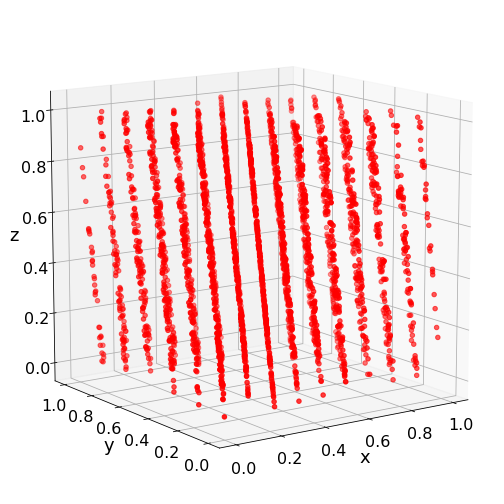

In [84]:
# Generating 3 x 1500 random numbers
rand_numbers = randssp(3, 3000)

# Allowing the notebook to produce graphs that allow rotations
%matplotlib widget

# Initiliasing a 3D figure
fig = plt.figure(" ", figsize=(7, 7))

# Defining the angles to see the hyperplanes

ax = fig.add_subplot(projection="3d", elev=12, azim=-125)
ax.set_box_aspect((1,1,1))
# Setting position of the plot
ax.set_position([0, 0, 1, 1])
ax.scatter(rand_numbers[0, :], rand_numbers[1, :], rand_numbers[2, :], color='r')

ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_zlabel('z', fontsize=18)

plt.show()


It can be seen that the points produced due to this method have a correlation. Hence we need a different method to produce the points that are uniformly distributed that does not pose this spectral problem.

### 1.2 Generating uniformly distributed random numbers that do not have the spectral problem

This can be done using the numpy library to draw uniform random numbers. This is done below.

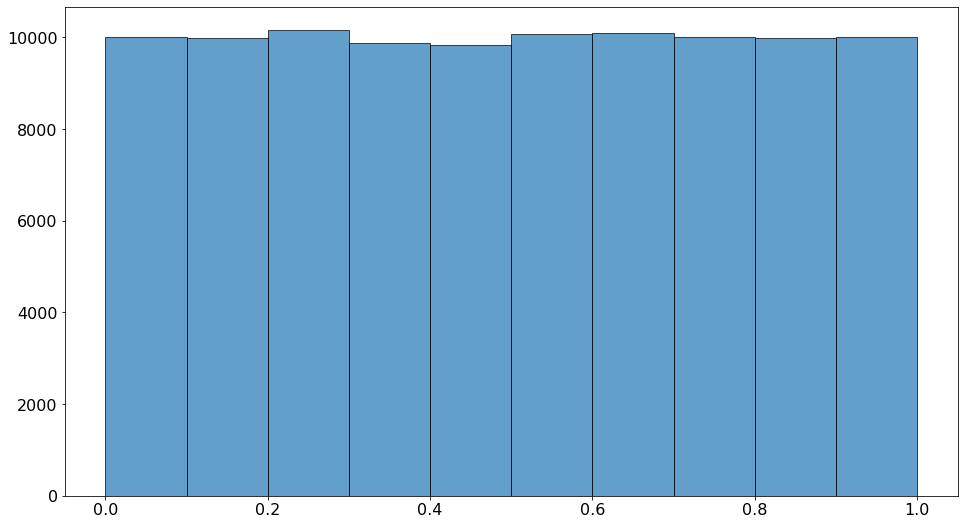

In [41]:
%matplotlib inline

# Generating 100,000 random numbers
rand_numbers = np.random.uniform(size=100000)
fig = plt.figure(figsize=(16, 9))

# Plotting a histogram
plt.hist(rand_numbers, alpha=0.7, edgecolor='k')
plt.show()


From the above histogram, it can be seen that the height of the bins tend to the same value as the number of random numbers is increased. So the probability of each bin having a certain height is approximately Gaussian-distributed. (verify)

So the random numbers generated are uniformly distributed. We can now do the spectral test.

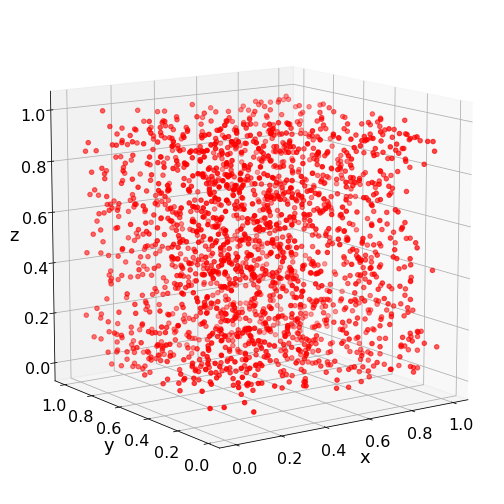

In [83]:
x_arr = np.random.uniform(size=2000)
y_arr = np.random.uniform(size=2000)
z_arr = np.random.uniform(size=2000)

# Allowing the notebook to produce graphs that allow rotations
%matplotlib widget

# Initiliasing a 3D figure
fig = plt.figure(" ", figsize=(7, 7))

# Defining the angles to see if the spectral problem exists

ax = fig.add_subplot(projection="3d", elev=12, azim=-125)
ax.set_box_aspect((1,1,1))
# Setting position of the plot
ax.set_position([0, 0, 1, 1])
ax.scatter(x_arr, y_arr, z_arr, color='r')

ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_zlabel('z', fontsize=18)

plt.show()


It is thus observed that the points generated using this method do not have the spectral problem.

## 2. Drawing samples from the exponential distribution

To simulate neutron motion, we need to draw points from the exponential distribution $e^{-x/\lambda}$. This can be done using the <b>Inverse Distribution Sampling / Cumulative Distribution Sampling</b>.

Given $pdf(x)=e^{-x}$, we can get the cdf as,
$$cdf(x) = \int_0^xpdf(x) = 1-e^{-x}$$

The inverse cdf is thus, 

$$cdf^{-1}(z) = -ln(1-z)$$

Implementing this, 

$$cdf^{-1} = -log(1-x)$$

So for a random number $u_i$,

$$x_i = -log(1-u_i)$$

As $u_i$ is a random number, $1-u_i$ can be simplified to a single random number aswell, giving the equation,

$$x_i = -log(u_i)$$

So for mean free path $\lambda$, 
$$P[x] = e^{-x/\lambda}$$ 

$$s_i = -{\lambda}log(u_i)$$

### 2.1 Theoretically calculating the mean free path

To generate the samples, we need a value of mean free path, this can be obtained using the cross sections of a material. For a material, the number of absorbing or scattering molecules can be obtained using the equation,

$$n = \frac{{\rho}N_A}{M}$$

where $\rho$ is the density of the material in $g/cm^3$, $N_A$ is Avogadro's number, and $M$ is the molar mass of the material in $g/mol$.

We can then define the total macroscopic cross section, $\Sigma_T$, considering only absorption and scattering as,

$$\Sigma_T = \Sigma_1 + \Sigma_2 = n(\sigma_a + \sigma_s)$$

where $\sigma_a$ is the absorption cross section (in barns) and $\sigma_s$ is the scattering cross section (in barns).

Hence, we can define the total mean free path $\lambda_T$ as,

$$\lambda_T = \frac{1}{\Sigma_T}$$

So we finally get,

$$P(x) = e^{-x/\lambda_T}$$

$$s_i = -\lambda_Tlog(u_i)$$

The mean free path calculation is implemented below.

In [43]:
def calculate_mean_free_path(density, molar_mass, absorption_cross_section, scattering_cross_section):
    """
    This function calculates the mean free path of a material in cm 
    with a given density, molar mass, absorption cross section, 
    and scattering cross section.
    
    Args:
        density: float
        molar_mass: float
        absorption_cross_section: float
        scattering_cross_section: float
        
    Returns:
        mean_free_path: float
    """
    n = (density * NA) / molar_mass
    mean_free_path = (1 / (n * (absorption_cross_section + scattering_cross_section))) * 10**24
    return mean_free_path


### 2.2 Drawing samples from the distribution

Drawing samples from the exponential distribution is given below.

In [44]:
def generate_exponential_values(n, mean_free_path):
    """
    This function draws n values from the exponential distribution given
    a mean free path.
    
    Args:
        n: int
        mean_free_path: float
        
    Returns:
        exp_arr: float array
    """
    random_arr = np.random.uniform(size=n)
    
    # Drawing samples from the distribution
    exp_arr = -mean_free_path * np.log(random_arr)
    return exp_arr


An example plot is given below with for water.

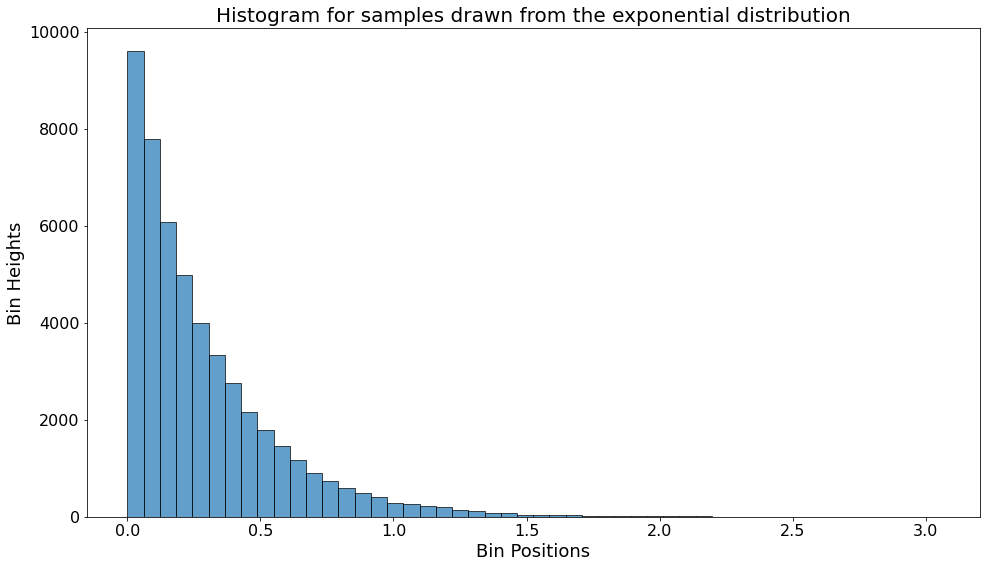

In [45]:
# Switching the notebook to inline plots
%matplotlib inline

# Values for water
molar_mass_water = 18.01528 # g/mol
density_water = 1.0 # g/cm^3
absorption_cross_section_water = 0.6652 # barn
scattering_cross_section_water = 103.0 # barn
mean_free_path_water = calculate_mean_free_path(density_water, molar_mass_water, absorption_cross_section_water, 
                                                scattering_cross_section_water) # in cm

# Drawing the exponential values

exp_arr = generate_exponential_values(50000, mean_free_path_water)

# Plotting the histogram

fig, ax = plt.subplots(figsize=(16, 9))
plt.title("Histogram for samples drawn from the exponential distribution", fontsize=20)
ax.set_xlabel("Bin Positions", fontsize=18)
ax.set_ylabel("Bin Heights", fontsize=18)
plt.hist(exp_arr, bins=50, alpha=0.7, edgecolor='k')

plt.show()


## 3. Verifying that the CDF sampling returns values consistent to the original distribution

One way to verify that the CDF sampling returns values consistent to the original distribution is to verify the Attenuation length of water. Attenuation length is the length a beam will travel in a material before its intensity drops be a factor of $1/e$. Attenuation length of water is $\lambda=45cm$. As attenuation follows the same exponential distribution as mean free path, we can use the same methods to draw values. This is done below.

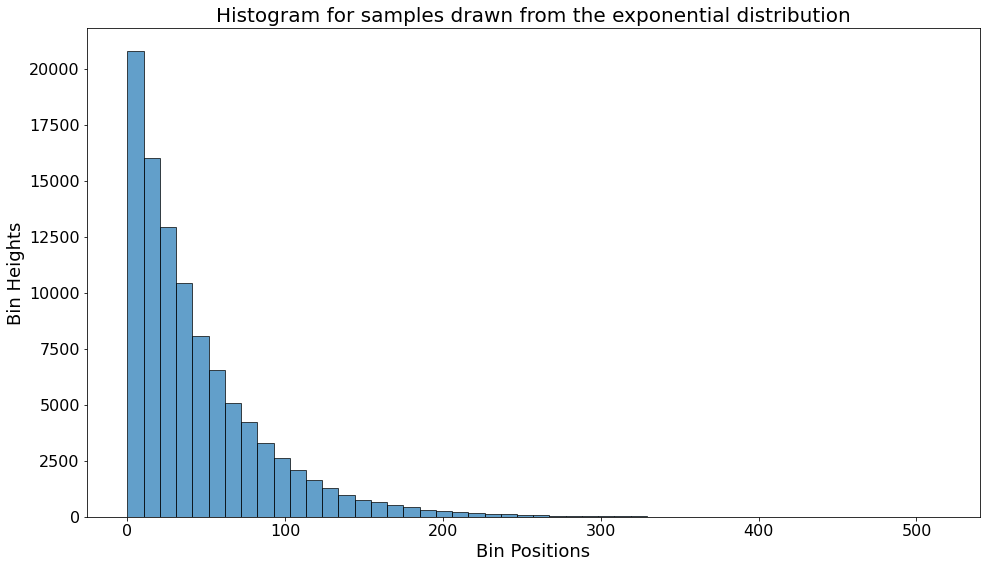

In [46]:
# Drawing the exponential values
attenuation_length = 45 # cm

exp_arr = generate_exponential_values(100000, attenuation_length)

# Plotting the histogram
%matplotlib inline

fig, ax = plt.subplots(figsize=(16, 9))
plt.title("Histogram for samples drawn from the exponential distribution", fontsize=20)
ax.set_xlabel("Bin Positions", fontsize=18)
ax.set_ylabel("Bin Heights", fontsize=18)
plt.hist(exp_arr, bins=50, alpha=0.7, edgecolor='k')

plt.show()


In order to obtain the attenuation length from the drawn samples, we can fit the log of heights of the bins against the bin positions. The slope of the fit gives $-1/\lambda$. The bin positions are taken as the midpoint of bin edges. This is done below.

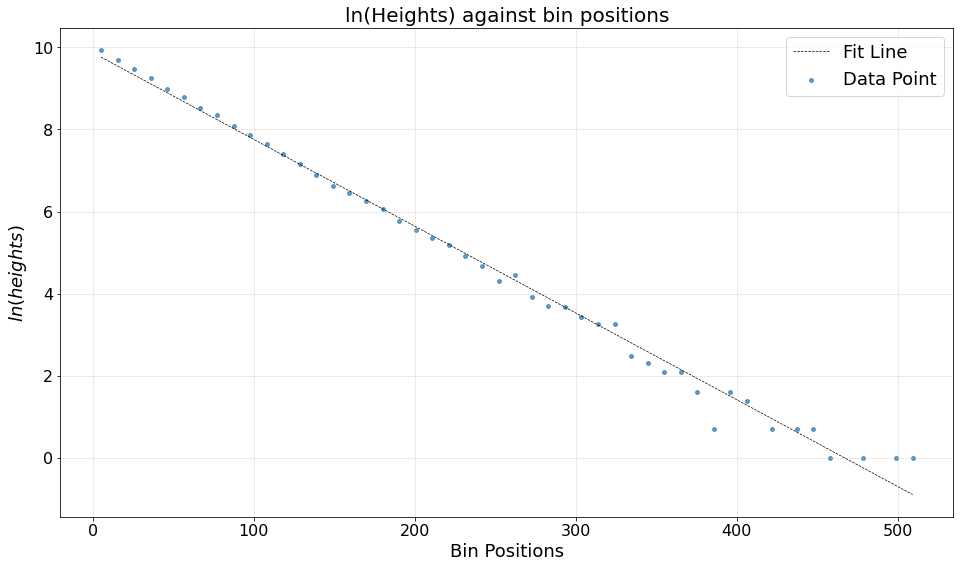

Obtained Attenuation Length: $\lambda = 47.3 ± 0.619$ $cm$

In [47]:
def calculate_bin_positions(bin_edges):
    """
    This function calculates bin positions by finding the midpoint
    of the bin edges.
    
    Args:
        bin_edges: float array
        
    Returns:
        bin_pos: float array
    """
    bin_pos = np.array([])
    for i in range(len(bin_edges)-1):
        temp = (bin_edges[i+1] + bin_edges[i]) / 2
        bin_pos = np.append(bin_pos, temp)
    return bin_pos

# Getting the bin heights and edges for 50 bins

bin_heights, bin_edges = np.histogram(exp_arr, bins=50)

# Removing bins with 0 height as logarithm needs to be used
bin_edges = np.delete(bin_edges, np.where(bin_heights == 0))
bin_heights = np.delete(bin_heights, np.where(bin_heights == 0))

bin_positions = calculate_bin_positions(bin_edges)

# Plotting and fitting the data

log_heights = np.log(bin_heights)

popt, pcov = np.polyfit(bin_positions, log_heights, deg=1, cov=True)

perr = np.sqrt(np.diag(pcov))

# Attenuation length given by -1/slope
# Error on the attenuation propagated as slope_err / slope^2

experimental_attenuation_length = np.array([-1/popt[0], perr[0]/(popt[0]**2)])

%matplotlib inline

fig, ax = plt.subplots(figsize=(16, 9))

plt.scatter(bin_positions, log_heights, s=15, alpha=0.7, label="Data Point")

# Plotting the fit line
plt.plot(bin_positions, popt[0]*bin_positions + popt[1], linestyle='--', color='k', linewidth=0.7, label="Fit Line")

plt.title("ln(Heights) against bin positions", fontsize=20)
plt.grid(alpha=0.3)
ax.set_xlabel("Bin Positions", fontsize=18)
ax.set_ylabel("$ln(heights)$", fontsize=18)
plt.legend(fontsize=18)
plt.show()

display(Markdown(r"Obtained Attenuation Length: $\lambda = {0:.3g} ± {1:.3g}$ $cm$".format(experimental_attenuation_length[0],
                                                                         experimental_attenuation_length[1])))

We can obtain a better value of the attenuation length by repeating this multiple times and then taking a weighted mean. This is done below.

In [48]:
attenuation_arr = np.empty((0, 2))

# Repeating 10 times
for i in range(10):
    attenuation_length = 45 # cm
    exp_arr = generate_exponential_values(1000000, attenuation_length)
    
    bin_heights, bin_edges = np.histogram(exp_arr, bins=50)

    # Removing bins with 0 height as logarithm needs to be used
    bin_edges = np.delete(bin_edges, np.where(bin_heights == 0))
    bin_heights = np.delete(bin_heights, np.where(bin_heights == 0))

    bin_positions = calculate_bin_positions(bin_edges)

    # Fitting the data

    log_heights = np.log(bin_heights)

    popt, pcov = np.polyfit(bin_positions, log_heights, deg=1, cov=True)

    perr = np.sqrt(np.diag(pcov))

    # Attenuation length given by -1/slope
    # Error on the attenuation propagated as slope_err / slope^2

    temp_arr = np.array([-1/popt[0], perr[0]/(popt[0]**2)])
    
    attenuation_arr = np.vstack((attenuation_arr, temp_arr))
    
# Attenuation given by weighted mean, error given by standard deviation
# These values are added to the following array

attenuation_value = np.array([np.average(attenuation_arr[:, 0], weights=attenuation_arr[:, 1]),
                             np.std(attenuation_arr[:, 0])])
display(Markdown(r"Obtained Attenuation Length: $\lambda = {0:.3g} ± {1:.3g}$ $cm$".format(attenuation_value[0],
                                                                         attenuation_value[1])))


Obtained Attenuation Length: $\lambda = 46.5 ± 1.07$ $cm$

Hence our obtained attenuation length agrees with the expected value. Thus CDF sampling draws values that follow the original distribution.

## 4. Simulating a Neutron random walk

To simulate a neutron random walk, we begin by generating isotropic points on a sphere. Isoptropic points have equal probabilities irrespective of the direction.

### 4.1 Generating isotropic points on a sphere

To generate isotropic unit vectors, or isotropic points on a sphere, $\vec{r} = x\hat{i} + y\hat{j} + z\hat{k}$ with $|\vec{r}|=1$; we can use spherical polar coordinates. This is given as,

$$r=constant$$

$$x_i = r\sin{\theta_i}\cos{\phi_i}$$

$$y_i = r\sin{\theta_i}\sin{\phi_i}$$

$$z_i = r\cos{\theta_i}$$

where $\theta_i$ and $\phi_i$ can be randomly generated within the range,

$$0 < \theta_i < \pi$$
$$0 < \phi_i < 2\pi$$

This is done below.

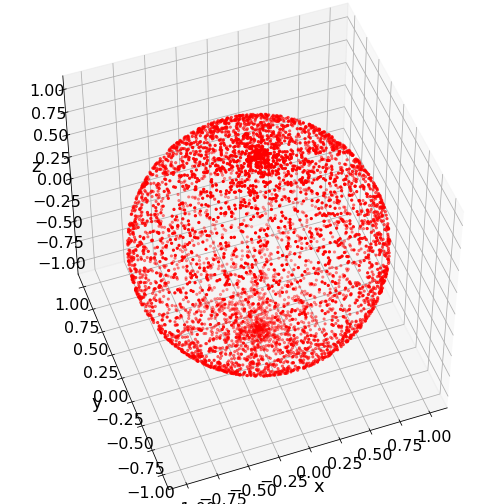

In [82]:
def generate_spherical(radius, n):
    """
    This function generates n isotropic vectors of a given radius in 3D
    space using spherical polar coordinates.
    
    Args:
        radius: float
        n: int
        
    Returns:
        x_arr: float array
        y_arr: float array
        z_arr: float array
    """
    theta = np.random.uniform(high=np.pi, size=n)
    phi = np.random.uniform(high=2*np.pi, size=n)
    x_arr = radius*np.sin(theta)*np.cos(phi)
    y_arr = radius*np.sin(theta)*np.sin(phi)
    z_arr = radius*np.cos(theta)
           
    return x_arr, y_arr, z_arr

# Plotting the points

x, y, z = generate_spherical(1, 5000)

# Allowing the notebook to produce graphs that allow rotations
%matplotlib widget

# Initiliasing a 3D figure
fig = plt.figure(" ", figsize=(7, 7))

# Defining the angles to see the poles

ax = fig.add_subplot(projection="3d", elev=49, azim=-110)
ax.set_box_aspect((1,1,1))
ax.set_position([0, 0, 1, 1])
ax.scatter(x, y, z, color='r', s=5)

ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_zlabel('z', fontsize=18)

plt.show()


From the above figure it can be seen that the points generated are not uniformly generated. There are poles forming on the sphere. This can be fixed by fixing the concentration of points generated at the poles. This can be done by using,

$$\theta_i = \cos^{-1}({1-2u_i})$$

This can be seen in the plot below.

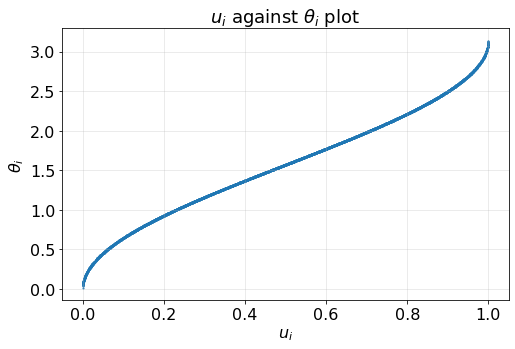

In [50]:
# Generating 10000 random numbers

u = np.random.uniform(size=10000)
theta = np.arccos(1-2*u)

%matplotlib inline

# Plotting theta against the random number

fig, ax = plt.subplots(figsize=(8, 5))
plt.title("$u_i$ against $\\theta_i$ plot", fontsize=18)
ax.set_xlabel("$u_i$", fontsize=16)
ax.set_ylabel("$\\theta_i$", fontsize=16)
plt.grid(alpha=0.3)
plt.scatter(u, theta, s=1)
plt.show()


From the plot it can be seen that at $u_i$ = 0 and 1, low concentration regions occur. This can now be implemented in generating the isotropic unit vectors.

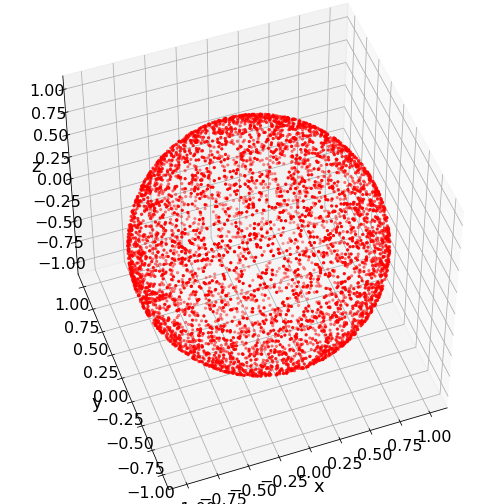

In [81]:
def generate_uniform_spherical(radius, n):
    """
    This function generates n isotropic vectors of a given radius while
    not producing poles. Hence the generated points are uniform.
    
    Args:
        radius: float
        n: int
        
    Returns:
        x_arr: float array
        y_arr: float array
        z_arr: float array
    """
    # This fixes the poles
    u = np.random.uniform(size=n)
    theta = np.arccos(1 - 2*u)
    phi = np.random.uniform(high=2*np.pi, size=n)
    x_arr = radius*np.sin(theta)*np.cos(phi)
    y_arr = radius*np.sin(theta)*np.sin(phi)
    z_arr = radius*np.cos(theta)
           
    return x_arr, y_arr, z_arr

# Example plot

x, y, z = generate_uniform_spherical(1, 5000)

# Allowing the notebook to produce graphs that allow rotations
%matplotlib widget

# Initiliasing a 3D figure
fig = plt.figure(" ", figsize=(7, 7))

ax = fig.add_subplot(projection="3d", elev=49, azim=-110)
ax.set_box_aspect((1,1,1))
ax.set_position([0, 0, 1, 1])
ax.scatter(x, y, z, color='r', s=5)

ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_zlabel('z', fontsize=18)

plt.show()


It can now be seen that the points generated are uniform.

### 4.2 Generating isotropic vectors with lengths distributed according to the exponential distribution

To generate a neutron random walk, we need isotropic vectors with lengths generated according to the exponential distribution. An example plot is done below.

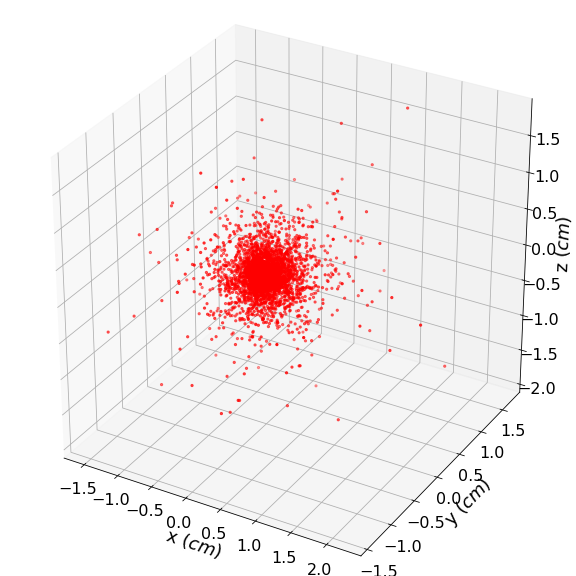

In [80]:
def generate_isotropic(n, mean_free_path):
    """
    This function generates isotropic vectors with lengths drawn from
    the exponential distribution exp(-x/lambda).
    
    Args:
        n: int
        mean_free_path: float
        
    Returns:
        x_arr: float array
        y_arr: float array
        z_arr: float array
    """
    length = generate_exponential_values(n, mean_free_path)
    x, y, z = generate_uniform_spherical(1, n)
    x_arr = length * x
    y_arr = length * y
    z_arr = length * z
    
    return x_arr, y_arr, z_arr

# Using mean free path of water and plotting the results

x, y, z = generate_isotropic(5000, mean_free_path_water)

%matplotlib widget

# Initiliasing a 3D figure
fig = plt.figure(" ", figsize=(8, 8))

ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect((1,1,1))
ax.set_position([0, 0, 1, 1])
ax.scatter(x, y, z, color='r', s=5)

ax.set_xlabel('x $(cm)$', fontsize=18)
ax.set_ylabel('y $(cm)$', fontsize=18)
ax.set_zlabel('z $(cm)$', fontsize=18)

plt.show()


### 4.3 Simulating random walks of a neutron incident on a material

We can now generate a neutron random walk that is incident on a material. We use the isotropic unit vector generation but the lengths are now distributed according the exponential distribution $e^{-x/\lambda}$ where $\lambda$ is the mean free path in a material.

To simulate a neutron random walk incident on a material, we assume that all neutrons begin at x=0, i.e, a collision with the surface. The first step a neutron takes will be normal to the surface, hence only in the positive x direction.  Each new generated vector is added to the previous one to move the neutron. This is implemented in the code below.

In [53]:
def generate_steps(step, mean_free_path):
    """
    This function generates steps taken by a neutron. The length is drawn from
    the exponential distribution and the vectors are isotropic. All neutrons
    start from (0, 0, 0) and the first step is always in the positive x
    direction.
    
    Args:
        step: int
        mean_free_path: float
    
    Returns:
        x: float
        y: float
        z: float
    """
    
    x_arr = np.array([])
    y_arr = np.array([])
    z_arr = np.array([])
    if step == 0:
        
        # Neutrons starting from (0, 0, 0)
        x = 0
        y = 0
        z = 0
        return x, y, z
    elif step == 1:
        
        # First step only in the positive x direction
        temp = np.random.uniform()
        
        #Length distributed according to the exponential function
        s = np.abs(-mean_free_path*np.log(temp))
        x=s
        y=0
        z=0            
        return x, y, z
    else:
        # Points after the first step
        temp = np.random.uniform()

        s = -mean_free_path*np.log(temp)

        u = np.random.uniform()

        theta = np.arccos(1 - 2*u)
        phi = np.random.uniform(high=2*np.pi)
        x = s*np.sin(theta)*np.cos(phi)
        y = s*np.sin(theta)*np.sin(phi)
        z = s*np.cos(theta)
        
        return x, y, z


An example plot of 25 steps in a random walk is shown below using mean free path of water.

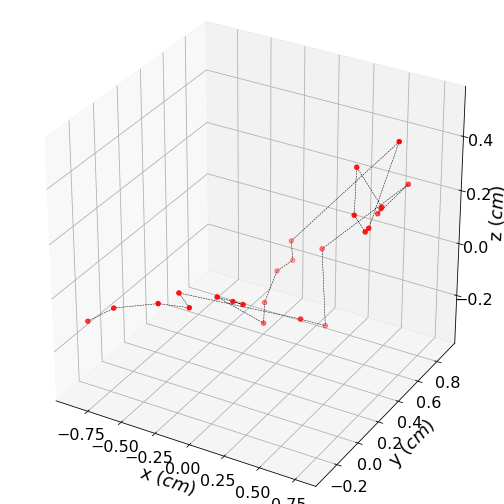

In [79]:
def generate_walk(steps, mean_free_path):
    """
    This function simulates a random walk for a given number of steps. This
    is done by iterating the previous vectors with new vectors generated
    using the generate_steps() function.
    
    Args:
        steps: int
        mean_free_path: float
        
    Returns:
        x_arr: float array
        y_arr: float array
        z_arr: float array
    """
    x_arr = np.empty(steps, dtype=float)
    y_arr = np.empty(steps, dtype=float)
    z_arr = np.empty(steps, dtype=float)
    for i in range(steps):
        if i == 0:
            x_arr[0], y_arr[0], z_arr[0] = generate_steps(i, mean_free_path)
        else:
            # Adding to the previous step to move the neutron
            x, y, z = generate_steps(i, mean_free_path)
            x_arr[i] = x + x_arr[i-1]
            y_arr[i] = y + y_arr[i-1]
            z_arr[i] = z + z_arr[i-1]
    return x_arr, y_arr, z_arr

# Generating 25 steps

x, y, z = generate_walk(25, mean_free_path_water)

%matplotlib widget

# Initiliasing a 3D figure
fig = plt.figure(" ", figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.set_box_aspect((1,1,1))
ax.set_position([0, 0, 1, 1])

ax.scatter(x, y, z, color='r')
ax.plot(x, y, z, linestyle='--', color='k', linewidth=0.5)

ax.set_xlabel('x $(cm)$', fontsize=18)
ax.set_ylabel('y $(cm)$', fontsize=18)
ax.set_zlabel('z $(cm)$', fontsize=18)

plt.show()


## 5. Simulating Neutrons in various materials

In order to simulate neutrons going through a material, we need the probability of scattering and absorption in that material. This is done using the equations,

$$P_a = \frac{\Sigma_a}{\Sigma_a + \Sigma_s}$$

$$P_s = \frac{\Sigma_s}{\Sigma_a + \Sigma_s}$$

where $P_a$ and $P_s$ are absorption and scattering probabilities respectively. 
<br>$\Sigma_a$ and $\Sigma_s$ are the macroscopic cross sections of absorption and scattering given by the equations,

$$\Sigma_a = n\sigma_a$$
$$\Sigma_s = n\sigma_s$$

where $n$ is the density of absorption or scattering molecules and $\sigma_a$ and $\sigma_s$ are the absorption and scattering cross sections of the material.

This calculation is done below.

In [55]:
def calculate_probabilities(density, molar_mass, absorption_cross_section, scattering_cross_section):
    """
    This function calculated absorption and scatterig probabilities of
    a material using the given density, molar mass, absorption, and
    scattering cross section.
    
    Args:
        density: float
        molar_mass: float
        absorption_cross_section: float
        scattering_cross_section: float

    Returns:
        prob_A: float
        prob_S: float
    """
    #Number of absorbing/scattering molecules
    n = (density * NA) / molar_mass
    
    #Calculating the macroscopic cross sections
    tot_sigmaA = n * absorption_cross_section
    tot_sigmaS = n * scattering_cross_section
    tot_sigma = tot_sigmaA + tot_sigmaS
    
    prob_A = tot_sigmaA/tot_sigma
    prob_S = tot_sigmaS/tot_sigma
    
    return prob_A, prob_S


When a neutron enters a material, a random number $u_i$ is generated, if that number is lower than the absorption probability, the neutron is absorbed. If the number is higher, the neutron scatters and continues moving. If the neutron leaves the material it is either considered back-scattered or transmitted depending on what side of the material it ends up. In our case, if it ends up on the left side of the material $x < 0$ it is considered back-scattered. If it ends up on the right side of the material $x>T$ where $T$ is the thickness of the material, it is considered transmitted.

In order to calculate absorption, transmission, and back scatter rates of a material, multiple neutrons are simulated going through the material. Each neutron begins at (0, 0, 0) and its first step is normal to the material.

If each neutron is simulated one at a time, it will be computationaly taxing, hence we bulk simulate the neutrons at the same time. This is implemented below.

In [56]:
def bulk_generate_steps(i, n, mean_free_path):
    """
    This function moves n neutrons simultaenously. Since only
    x direction is required for the simulations, this function
    only generates x values. These are generated isotropically.
    The initial position generated is 0 and the first step
    is always in the positive x direction. The lengths are
    distributed according to the exponential distribution.
    
    Args:
        i: int
        n: int
        mean_free_path: float

    Returns:
        x_arr: float array of size n
    """   
    # Initializing an empty array of size n
    x_arr = np.empty(n, dtype=float)
    if i == 0:
        # Generating n initial values of x=0
        x_arr = np.repeat(0, n)
    elif i == 1:
        # First step is in the positive x direction
        x_arr = np.abs(-mean_free_path * np.log(np.random.uniform(size=n)))
    else:
        # Subsequent steps are isotropic. x values for n neutrons are generated
        
        s = -mean_free_path * np.log(np.random.uniform(size=n))
        phi = np.random.uniform(high=2*np.pi, size=n)
        theta = np.arccos(1 - (2 * np.random.uniform(size=n)))
        x_arr = s*np.sin(theta)*np.cos(phi)
    
    return x_arr

def bulk_generate_probabilities(n):
    """
    This function generates n random values corresponding to n neutrons.
    This is then compared to absorption probability to determine if
    neutron is absorbed or scattered.
    
    Args:
        n: int
        
    Returns:
        probs: float array of size n
    """
    # Generating random number between 0 and 1, uniformly distributed
    probs = np.random.uniform(size=n)        
    return probs

def simulate_neutrons(n, absorption_probability, mean_free_path, thickness=None):
    """
    This function simulates n neutrons simultaneously. Each neutron's random walk
    is independent of the other. This bulk simulation is accompalished using numpy
    arrays. The function then returns the number of absorbed, transmitted (if
    finite thickness), and reflected neutrons.
    
    Args:
        n: int
        absorption_probability: float
        mean_free_path: float
        thickness: float, default None
    
    Returns:
        absorbed: int
        transmitted: int
        reflected: int
    """
    # Initializing the neutrons
    x = bulk_generate_steps(0, n, mean_free_path)
    i = 1
    absorbed = 0
    reflected = 0
    # Checking if finite thickness given or not
    if thickness != None:
        transmitted = 0
    
    # The loop runs till there are no neutrons left
    while len(x) > 0:
        
        # Neutrons that have x < 0 are considered reflected
        
        reflected += len(np.argwhere(x < 0))
        if thickness != None:
            # Neutrons above x > thickness are considered transmitted
            transmitted += len(np.argwhere(x > thickness))

        # The reflected and transmitted neutrons are then deleted from the array of neutrons
        x = np.delete(x, np.argwhere(x < 0))
        if thickness != None:
            x = np.delete(x, np.argwhere(x > thickness))

        # A new length of the array is determined to generate probabilities
        gen_n = len(x)
        
        # Probabilities associated with each neutron are generated
        probs = bulk_generate_probabilities(gen_n)
        
        # Neutrons with probabilities lower than absorption probability are considered absorbed
        # and deleted from the array of neutrons.

        absorbed += len(np.argwhere(probs <= absorption_probability)) 
        x = np.delete(x, np.argwhere(probs <= absorption_probability))
        
        # A new size is determined for the array, and the left over neutrons are moved by another step
        # given by deltaX
        
        new_size = len(x)
        deltaX = bulk_generate_steps(i, new_size, mean_free_path)
        x = x + deltaX
        i += 1
    
    if thickness != None:
        return absorbed, transmitted, reflected
    else:
        return absorbed, reflected


### 5.1 Considering infinite medium

In an infinite medium, there is no transmission and only backscattering and absorption. This is done below for various materials.

### 5.1.1 Water
The simulation for water is done below.

In [57]:
number_of_neutrons = 10000

# Parameters for Water

absorption_cross_section_water = 0.6652 # barn
scattering_cross_section_water = 103.0 # barn
molar_mass_water = 18.01528 # g/mol
density_water = 1.0 # g/cm^3
mean_free_path_water = calculate_mean_free_path(density_water, molar_mass_water, 
                                                absorption_cross_section_water, scattering_cross_section_water)

# The absorption and scattering probabilities in Water
prob_A_water, prob_S_water = calculate_probabilities(density_water, molar_mass_water, absorption_cross_section_water, 
                            scattering_cross_section_water)  

# Infinite Medium

inf_absorbed_water, inf_reflected_water = simulate_neutrons(number_of_neutrons, 
                                                         prob_A_water, mean_free_path_water)
print("--------------------")
print("Infinite Medium - Water")
print("--------------------")
print("Total Neutrons: {0}".format(number_of_neutrons))
print("Percentage of Neutrons Absorbed: {0}%".format(inf_absorbed_water * 100/number_of_neutrons))
print("Percentage of Neutrons Reflected: {0}%".format(inf_reflected_water * 100/number_of_neutrons))


--------------------
Infinite Medium - Water
--------------------
Total Neutrons: 10000
Percentage of Neutrons Absorbed: 20.98%
Percentage of Neutrons Reflected: 79.02%


### 5.1.2 Lead
The simulation for lead is done below.

In [58]:
number_of_neutrons = 10000

# Parameters for lead

absorption_cross_section_lead = 0.158 # barn
scattering_cross_section_lead = 11.221 # barn
molar_mass_lead = 207.2  # g/mol
density_lead = 11.35 # g/cm^3
mean_free_path_lead = calculate_mean_free_path(density_lead, molar_mass_lead, 
                                                absorption_cross_section_lead, scattering_cross_section_lead)

# The absorption and scattering probabilities in lead
prob_A_lead, prob_S_lead = calculate_probabilities(density_lead, molar_mass_lead, absorption_cross_section_lead, 
                            scattering_cross_section_lead)   
# Infinite Medium

inf_absorbed_lead, inf_reflected_lead = simulate_neutrons(number_of_neutrons, 
                                                         prob_A_lead, mean_free_path_lead)
print("--------------------")
print("Infinite Medium - Lead")
print("--------------------")
print("Total Neutrons: {0}".format(number_of_neutrons))
print("Percentage of Neutrons Absorbed: {0}%".format(inf_absorbed_lead * 100/number_of_neutrons))
print("Percentage of Neutrons Reflected: {0}%".format(inf_reflected_lead * 100/number_of_neutrons))


--------------------
Infinite Medium - Lead
--------------------
Total Neutrons: 10000
Percentage of Neutrons Absorbed: 28.4%
Percentage of Neutrons Reflected: 71.6%


### 5.1.3 Graphite
The simulation for graphite is done below.

In [59]:
number_of_neutrons = 10000

# Parameters for Graphite

absorption_cross_section_graphite = 0.0045 # barn
scattering_cross_section_graphite = 4.74 # barn
molar_mass_graphite = 12.011  # g/mol
density_graphite = 1.67 # g/cm^3
mean_free_path_graphite = calculate_mean_free_path(density_graphite, molar_mass_graphite, 
                                                absorption_cross_section_graphite, scattering_cross_section_graphite)

# The absorption and scattering probabilities in Graphite
prob_A_graphite, prob_S_graphite = calculate_probabilities(density_graphite, molar_mass_graphite, 
                                                           absorption_cross_section_graphite, molar_mass_graphite)   
# Infinite Medium

inf_absorbed_graphite, inf_reflected_graphite = simulate_neutrons(number_of_neutrons, 
                                                         prob_A_graphite, mean_free_path_graphite)
print("--------------------")
print("Infinite Medium - Graphite")
print("--------------------")
print("Total Neutrons: {0}".format(number_of_neutrons))
print("Percentage of Neutrons Absorbed: {0}%".format(inf_absorbed_graphite * 100/number_of_neutrons))
print("Percentage of Neutrons Reflected: {0}%".format(inf_reflected_graphite * 100/number_of_neutrons))


--------------------
Infinite Medium - Graphite
--------------------
Total Neutrons: 10000
Percentage of Neutrons Absorbed: 5.48%
Percentage of Neutrons Reflected: 94.52%


### 5.1.4 Summarizing the results
The results for the various materials are summarized below.

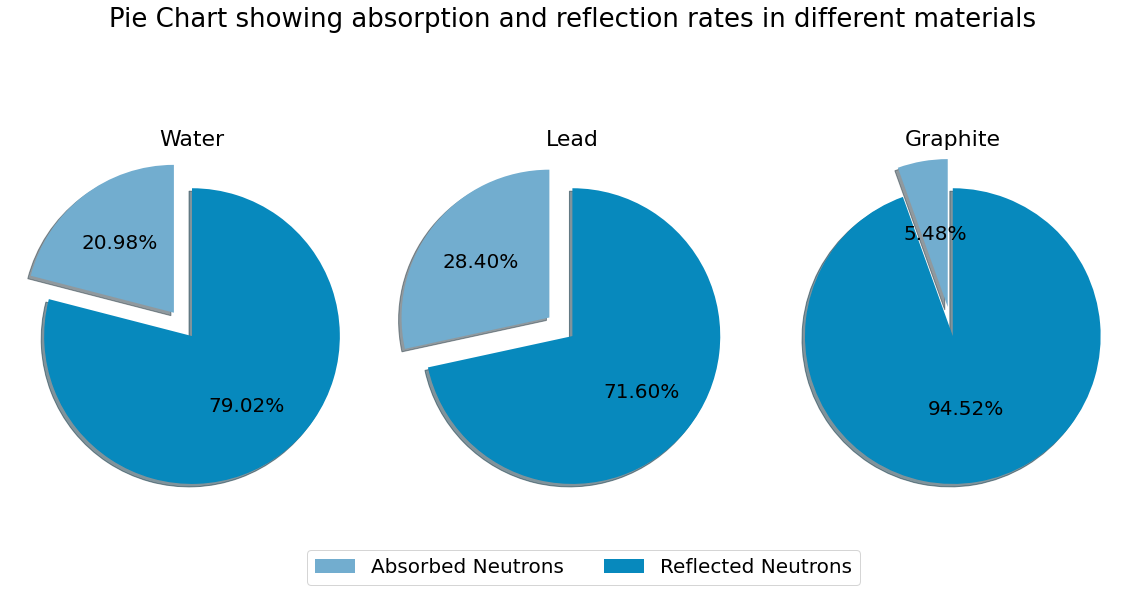

In [60]:
%matplotlib inline

# Creating the plots
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9))

# Creating the pie charts
fig.suptitle("Pie Chart showing absorption and reflection rates in different materials", fontsize=26)

sizes_water = np.array([inf_absorbed_water, inf_reflected_water]) * 100/number_of_neutrons
sizes_lead = np.array([inf_absorbed_lead, inf_reflected_lead]) * 100/number_of_neutrons
sizes_graphite = np.array([inf_absorbed_graphite, inf_reflected_graphite]) * 100/number_of_neutrons

# Defining the default labels and colors
labels = ["Absorbed Neutrons", "Reflected Neutrons"]
explode = (0.2, 0)
colors = ["#72adcf", "#0789bd"]

ax1.set_title('Water', fontsize=22)
ax1.pie(sizes_water, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, 
        textprops={'fontsize': 20}, startangle=90)

ax2.set_title('Lead', fontsize=22)
ax2.pie(sizes_lead, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, 
        textprops={'fontsize': 20}, startangle=90)

ax3.set_title('Graphite', fontsize=22)
ax3.pie(sizes_graphite, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, 
        textprops={'fontsize': 20}, pctdistance=0.5, startangle=90)

plt.tight_layout()
plt.legend(labels, fontsize=20, loc='lower center', bbox_to_anchor=(-0.5, -0.2), fancybox=True, ncol=2)
plt.show()


It is thus observed that lead has a higher absorption rate out of all. While graphite reflects the most amount of neutrons.

### 5.2 Simulating neutrons going through a slab of material of finite thickness

When a slab of a material of finite thickness is taken, neutrons can penetrate through the material hence there is transmission of neutrons through the material. The rates for various materials are calculated below.

### 5.2.1 Water
The simulation for water is done below.

In [61]:
number_of_neutrons = 10000

# Reusing data from before

# Finite Medium

thickness = 10 # cm

absorbed_water, transmitted_water, reflected_water = simulate_neutrons(number_of_neutrons, 
                                                         prob_A_water, mean_free_path_water, thickness=thickness)
print("--------------------")
print("Water of thickness {0} cm".format(thickness))
print("--------------------")
print("Total Neutrons: {0}".format(number_of_neutrons))
print("Percentage of Neutrons Absorbed: {0}%".format(absorbed_water * 100/number_of_neutrons))
print("Percentage of Neutrons Transmitted: {0}%".format(transmitted_water * 100/number_of_neutrons))
print("Percentage of Neutrons Reflected: {0}%".format(reflected_water * 100/number_of_neutrons))


--------------------
Water of thickness 10 cm
--------------------
Total Neutrons: 10000
Percentage of Neutrons Absorbed: 20.42%
Percentage of Neutrons Transmitted: 0.31%
Percentage of Neutrons Reflected: 79.27%


### 5.2.2 Lead
The simulation for lead is done below.

In [62]:
number_of_neutrons = 10000

# Reusing data from before

# Finite Medium

thickness = 10 # cm

absorbed_lead, transmitted_lead, reflected_lead = simulate_neutrons(number_of_neutrons, 
                                                         prob_A_lead, mean_free_path_lead, thickness=thickness)
print("--------------------")
print("Lead of thickness {0} cm".format(thickness))
print("--------------------")
print("Total Neutrons: {0}".format(number_of_neutrons))
print("Percentage of Neutrons Absorbed: {0}%".format(absorbed_lead * 100/number_of_neutrons))
print("Percentage of Neutrons Transmitted: {0}%".format(transmitted_lead * 100/number_of_neutrons))
print("Percentage of Neutrons Reflected: {0}%".format(reflected_lead * 100/number_of_neutrons))


--------------------
Lead of thickness 10 cm
--------------------
Total Neutrons: 10000
Percentage of Neutrons Absorbed: 11.38%
Percentage of Neutrons Transmitted: 27.98%
Percentage of Neutrons Reflected: 60.64%


### 5.2.3 Graphite
The simulation for graphite is done below.

In [63]:
number_of_neutrons = 10000

# Reusing data from before

# Finite Medium

thickness = 10 # cm

absorbed_graphite, transmitted_graphite, reflected_graphite = simulate_neutrons(number_of_neutrons, 
                                                         prob_A_graphite, mean_free_path_graphite, thickness=thickness)
print("--------------------")
print("Graphite of thickness {0} cm".format(thickness))
print("--------------------")
print("Total Neutrons: {0}".format(number_of_neutrons))
print("Percentage of Neutrons Absorbed: {0}%".format(absorbed_graphite * 100/number_of_neutrons))
print("Percentage of Neutrons Transmitted: {0}%".format(transmitted_graphite * 100/number_of_neutrons))
print("Percentage of Neutrons Reflected: {0}%".format(reflected_graphite * 100/number_of_neutrons))


--------------------
Graphite of thickness 10 cm
--------------------
Total Neutrons: 10000
Percentage of Neutrons Absorbed: 0.38%
Percentage of Neutrons Transmitted: 31.08%
Percentage of Neutrons Reflected: 68.54%


## 5.3 Error Analysis on various rates for materials having finite thickness

Errors on the absorption, transmission, and reflection rates can be found by running simulations multiple times and then taking an average of the neutron counts and taking a standard deviation of the data as the error. 10 simulations are done for each material. This is done below for different materials.

### 5.3.1 Water
The simulation for water is done below.

In [64]:
number_of_simulations = 10
absorbed_water_arr = np.empty(number_of_simulations, dtype=float)
transmitted_water_arr = np.empty(number_of_simulations, dtype=float)
reflected_water_arr = np.empty(number_of_simulations, dtype=float)

thickness = 10 # cm

# Repeating each simulation number_of_simulations times
for i in range(number_of_simulations):
    # 10000 neutrons simulated each run
    absorbed, transmitted, reflected = simulate_neutrons(10000, prob_A_water, mean_free_path_water, 
                                                             thickness=thickness)
    absorbed_water_arr[i] = absorbed
    transmitted_water_arr[i] = transmitted
    reflected_water_arr[i] = reflected
    
# Creating array of final values with error
# Rounded to integer values
absorbed_water = np.array([floor(np.mean(absorbed_water_arr)), floor(np.std(absorbed_water_arr))])
transmitted_water = np.array([floor(np.mean(transmitted_water_arr)), floor(np.std(transmitted_water_arr))])
reflected_water = np.array([floor(np.mean(reflected_water_arr)), floor(np.std(reflected_water_arr))])

print("--------------------")
print("Water of thickness {0} cm".format(thickness))
print("--------------------")
print("Neutrons per simulation: {0}".format(number_of_neutrons))
print("Neutrons Absorbed: {0} ± {1}".format(absorbed_water[0], absorbed_water[1]))
print("Neutrons Transmitted: {0} ± {1}".format(transmitted_water[0], transmitted_water[1]))
print("Neutrons Reflected: {0} ± {1}".format(reflected_water[0], reflected_water[1]))


--------------------
Water of thickness 10 cm
--------------------
Neutrons per simulation: 10000
Neutrons Absorbed: 2065 ± 35
Neutrons Transmitted: 30 ± 4
Neutrons Reflected: 7904 ± 35


### 5.3.2 Lead
The simulation for lead is done below.

In [65]:
number_of_simulations = 10
absorbed_lead_arr = np.empty(number_of_simulations, dtype=float)
transmitted_lead_arr = np.empty(number_of_simulations, dtype=float)
reflected_lead_arr = np.empty(number_of_simulations, dtype=float)

thickness = 10 # cm
for i in range(number_of_simulations):
    # 10000 neutrons simulated each run
    absorbed, transmitted, reflected = simulate_neutrons(10000, prob_A_lead, mean_free_path_lead, 
                                                             thickness=thickness)
    absorbed_lead_arr[i] = absorbed
    transmitted_lead_arr[i] = transmitted
    reflected_lead_arr[i] = reflected
    
# Creating array of final values with error
# Rounded to integer values
absorbed_lead = np.array([floor(np.mean(absorbed_lead_arr)), floor(np.std(absorbed_lead_arr))])
transmitted_lead = np.array([floor(np.mean(transmitted_lead_arr)), floor(np.std(transmitted_lead_arr))])
reflected_lead = np.array([floor(np.mean(reflected_lead_arr)), floor(np.std(reflected_lead_arr))])

print("--------------------")
print("Lead of thickness {0} cm".format(thickness))
print("--------------------")
print("Neutrons per simulation: {0}".format(number_of_neutrons))
print("Neutrons Absorbed: {0} ± {1}".format(absorbed_lead[0], absorbed_lead[1]))
print("Neutrons Transmitted: {0} ± {1}".format(transmitted_lead[0], transmitted_lead[1]))
print("Neutrons Reflected: {0} ± {1}".format(reflected_lead[0], reflected_lead[1]))


--------------------
Lead of thickness 10 cm
--------------------
Neutrons per simulation: 10000
Neutrons Absorbed: 1129 ± 33
Neutrons Transmitted: 2767 ± 37
Neutrons Reflected: 6103 ± 48


### 5.3.3 Graphite
The simulation for graphite is done below.

In [66]:
number_of_simulations = 10
absorbed_graphite_arr = np.empty(number_of_simulations, dtype=float)
transmitted_graphite_arr = np.empty(number_of_simulations, dtype=float)
reflected_graphite_arr = np.empty(number_of_simulations, dtype=float)

thickness = 10 # cm
for i in range(number_of_simulations):
    # 10000 neutrons simulated each run
    absorbed, transmitted, reflected = simulate_neutrons(10000, prob_A_graphite, mean_free_path_graphite, 
                                                             thickness=thickness)
    absorbed_graphite_arr[i] = absorbed
    transmitted_graphite_arr[i] = transmitted
    reflected_graphite_arr[i] = reflected
    
# Creating array of final values with error
# Rounded to integer values
absorbed_graphite = np.array([floor(np.mean(absorbed_graphite_arr)), floor(np.std(absorbed_graphite_arr))])
transmitted_graphite = np.array([floor(np.mean(transmitted_graphite_arr)), floor(np.std(transmitted_graphite_arr))])
reflected_graphite = np.array([floor(np.mean(reflected_graphite_arr)), floor(np.std(reflected_graphite_arr))])

print("--------------------")
print("Lead of thickness {0} cm".format(thickness))
print("--------------------")
print("Neutrons per simulation: {0}".format(number_of_neutrons))
print("Neutrons Absorbed: {0} ± {1}".format(absorbed_graphite[0], absorbed_graphite[1]))
print("Neutrons Transmitted: {0} ± {1}".format(transmitted_graphite[0], transmitted_graphite[1]))
print("Neutrons Reflected: {0} ± {1}".format(reflected_graphite[0], reflected_graphite[1]))


--------------------
Lead of thickness 10 cm
--------------------
Neutrons per simulation: 10000
Neutrons Absorbed: 34 ± 5
Neutrons Transmitted: 3103 ± 41
Neutrons Reflected: 6862 ± 41


### 5.3.4 Summarizing the data
The results for the various materials are summarized below.

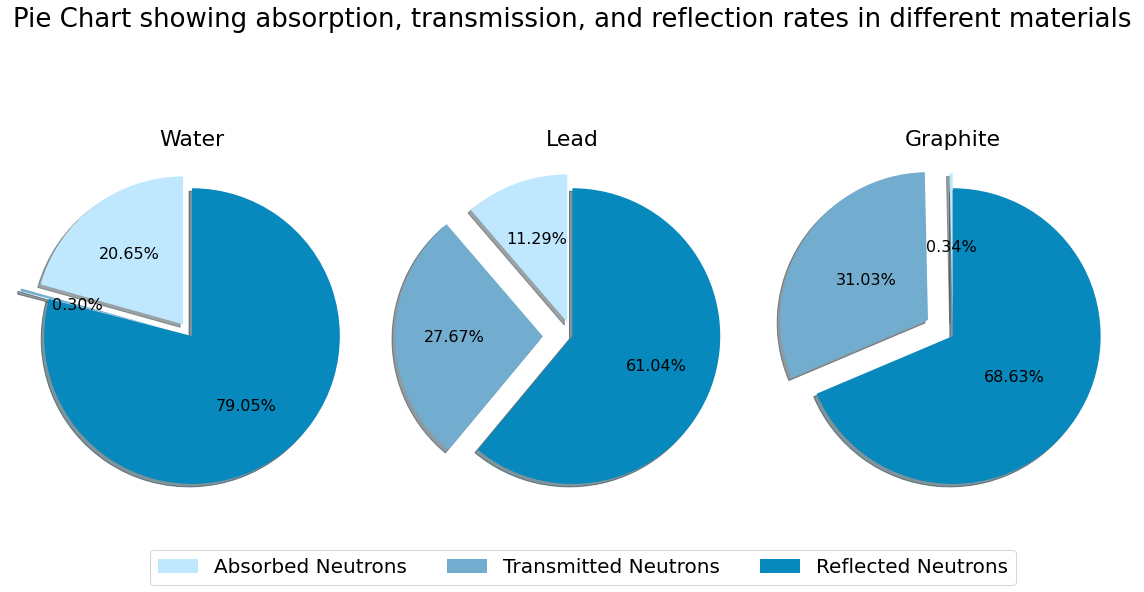

In [67]:
%matplotlib inline

# Creating the plots
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9))

fig.suptitle("Pie Chart showing absorption, transmission, and reflection rates in different materials", fontsize=26)

# Defining the data for the pie chart
sizes_water = np.array([absorbed_water[0], transmitted_water[0], reflected_water[0]]) * 100/number_of_neutrons
sizes_lead = np.array([absorbed_lead[0], transmitted_lead[0], reflected_lead[0]]) * 100/number_of_neutrons
sizes_graphite = np.array([absorbed_graphite[0], transmitted_graphite[0], reflected_graphite[0]]) * 100/number_of_neutrons

# Defining the labels and colors for the pie chart
labels = ["Absorbed Neutrons", "Transmitted Neutrons", "Reflected Neutrons"]
explode = (0.1, 0.2, 0)
colors = ["#bfe8ff", "#72adcf", "#0789bd"]

ax1.set_title('Water', fontsize=22)
ax1.pie(sizes_water, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, 
        textprops={'fontsize': 16}, startangle=90)

ax2.set_title('Lead', fontsize=22)
ax2.pie(sizes_lead, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, 
        textprops={'fontsize': 16}, startangle=90)

ax3.set_title('Graphite', fontsize=22)
ax3.pie(sizes_graphite, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, 
        textprops={'fontsize': 16}, pctdistance=0.5, startangle=90)

plt.tight_layout()
plt.legend(labels, fontsize=20, loc='lower center', bbox_to_anchor=(-0.5, -0.2), fancybox=True, ncol=3)
plt.show()


It is thus observed that water reflects most neutrons and has the highest absorption rate out of the three materials. Graphite allows the most amount of transmission while absorbing almost no neutrons. <b>Thus from this result, water is a better shielding material for thermal neutrons.</b>

## 6. Variation of errors with increase in number of neutrons

To analyse the variation of errors with an increase in number of neutrons, we use lead of thickness 10 cm for our simulation and obtain errors for multiple number of neutrons. Each simulation is repeated 30 times to obtain errors. This is done below.

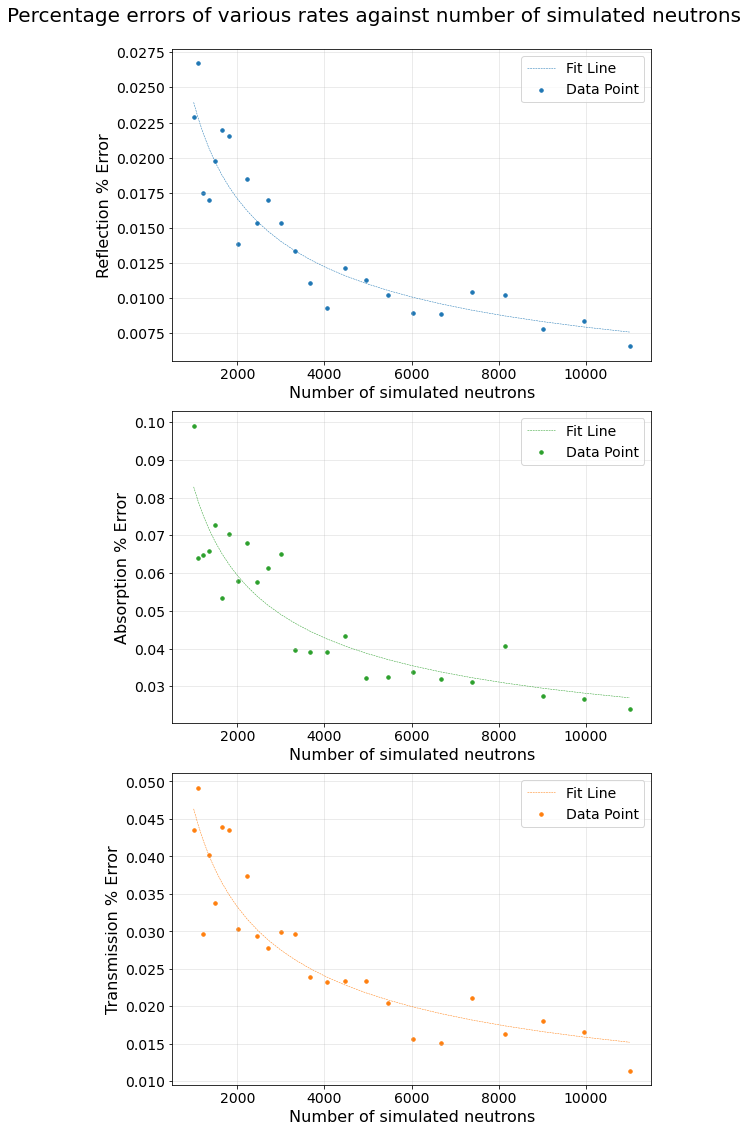

In [68]:
# logarthmically varyign the number of neutrons from 1000 to 11000, 25 points
number_of_neutron_arr = np.floor(np.geomspace(1000, 11000, 25)).astype(int)

def inverse_sqrt(x, m, c):
    """
    Function that returns 1/sqrt(x) function.
    
    Args:
        x: float
        m: float
        c: float
    Returns:
        y: float
    """
    y = (m/np.sqrt(x)) + c
    return y

# 2D arrays to contain the final values and errors
final_absorbed_arr_lead = np.empty((0, 2))
final_transmitted_arr_lead = np.empty((0, 2))
final_reflected_arr_lead = np.empty((0, 2))

start_time = time.time()
for i in range(len(number_of_neutron_arr)):
    
    # The amount of times a simulation is repeated
    
    number_of_simulations = 30
    absorbed_arr_lead = np.empty(number_of_simulations, dtype=float)
    transmitted_arr_lead = np.empty(number_of_simulations, dtype=float)
    reflected_arr_lead = np.empty(number_of_simulations, dtype=float)
    
    thickness = 10 # cm
    for j in range(number_of_simulations):
        absorbed, transmitted, reflected = simulate_neutrons(number_of_neutron_arr[i], 
                                                                 prob_A_lead, mean_free_path_lead, thickness=thickness)
        absorbed_arr_lead[j] = absorbed
        transmitted_arr_lead[j] = transmitted
        reflected_arr_lead[j] = reflected
    
    # Final value calculated as the mean, the error is the standard deviation
    # These values are then pushed the 2D arrays
    final_absorbed = floor(np.mean(absorbed_arr_lead))
    final_absorbed_err = floor(np.std(absorbed_arr_lead))

    final_transmitted = floor(np.mean(transmitted_arr_lead))
    final_transmitted_err = floor(np.std(transmitted_arr_lead))

    final_reflected = floor(np.mean(reflected_arr_lead))
    final_reflected_err = floor(np.std(reflected_arr_lead))
    
    final_absorbed_arr_lead = np.vstack((final_absorbed_arr_lead, 
                                    np.array([final_absorbed, 
                                              final_absorbed_err])))
    final_transmitted_arr_lead = np.vstack((final_transmitted_arr_lead, 
                                       np.array([final_transmitted, 
                                                 final_transmitted_err])))
    final_reflected_arr_lead = np.vstack((final_reflected_arr_lead, 
                                     np.array([final_reflected, 
                                               final_reflected_err])))
# Plot
    
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 16))
fig.suptitle("Percentage errors of various rates against number of simulated neutrons\n", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=13)

# Plotting number of neutrons against % error and fitting 1/sqrt(x) function to the plots
ax1.scatter(number_of_neutron_arr, final_reflected_arr_lead[:, 1]/final_reflected_arr_lead[:, 0],
           color='tab:blue', s=12, label='Data Point')
popt, pcov = curve_fit(inverse_sqrt, number_of_neutron_arr, final_reflected_arr_lead[:, 1]/final_reflected_arr_lead[:, 0],
                       maxfev=50000)
ax1.plot(number_of_neutron_arr, inverse_sqrt(number_of_neutron_arr, popt[0], popt[1]),
           color='tab:blue', linestyle='--', linewidth=0.5, label='Fit Line')
ax1.set_ylabel("Reflection % Error", fontsize=16)
ax1.set_xlabel("Number of simulated neutrons", fontsize=16)
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.legend(fontsize=14)

ax2.scatter(number_of_neutron_arr, final_absorbed_arr_lead[:, 1]/final_absorbed_arr_lead[:, 0],
           color='tab:green', s=12, label='Data Point')
popt, pcov = curve_fit(inverse_sqrt, number_of_neutron_arr, final_absorbed_arr_lead[:, 1]/final_absorbed_arr_lead[:, 0],
                       maxfev=50000)
ax2.plot(number_of_neutron_arr, inverse_sqrt(number_of_neutron_arr, popt[0], popt[1]),
           color='tab:green', linestyle='--', linewidth=0.5, label='Fit Line')
ax2.set_ylabel("Absorption % Error", fontsize=16)
ax2.set_xlabel("Number of simulated neutrons", fontsize=16)
ax2.grid(alpha=0.3)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(fontsize=14)

ax3.scatter(number_of_neutron_arr, final_transmitted_arr_lead[:, 1]/final_transmitted_arr_lead[:, 0],
           color='tab:orange', s=12, label='Data Point')
# ax3.plot(number_of_neutron_arr, final_transmitted_arr_lead[:, 1]/final_transmitted_arr_lead[:, 0],
#            color='tab:orange', linestyle='--', linewidth=0.5)
popt, pcov = curve_fit(inverse_sqrt, number_of_neutron_arr, final_transmitted_arr_lead[:, 1]/final_transmitted_arr_lead[:, 0],
                       maxfev=50000)
ax3.plot(number_of_neutron_arr, inverse_sqrt(number_of_neutron_arr, popt[0], popt[1]),
           color='tab:orange', linestyle='--', linewidth=0.5, label='Fit Line')
ax3.set_ylabel("Transmission % Error", fontsize=16)
ax3.set_xlabel("Number of simulated neutrons", fontsize=16)
ax3.grid(alpha=0.3)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.legend(fontsize=14)

plt.tight_layout()
plt.show()


As this is a type of Monte Carlo simulation, the error varies as $1/\sqrt{N}$ where $N$ the number of neutrons. This functional dependence of errors on $N$ can be seen in the percentage error against number of simulated neutrons plot above from the fitted function. The plots show the cases for asborbed, transmitted, and reflected neutrons. 

## 7. Attenuation length and variation in neutron transmission, reflection and absorption with slab thickness

The rates of neutrion transmission, reflection, and absorption vary with thickness of the material. As thickness increases, absorption increases and transmission falls. This is useful in calculating the attenuation length of neutrons in the material. As attenuation length is the length a beam travels before it intensity drops by a factor of $1/e$, we can plot logarithm of transmitted neutrons to the slab thickness, and fit the data to obtain the slope as $-1/\lambda$ where $\lambda$ is the attenuation length. The same code as previous can be used as attenuation length and mean free path follow the same distribution $e^{-x/\lambda}$.

This is implemented in the code below.

In [69]:
def line(x, m, c):
    """
    Function that returns a line.
    
    Args:
        x: float
        m: float
        c: float
    Returns:
        y: float
    """
    y = m*x + c
    return y

def calculate_attenuation_and_variation(thickness_array, mean_free_path, absorption_probability):
    """
    This function calculates and plots the variation of absorption, transmission,
    and reflection rates of neutrons in a given material with varying thickness.
    The transmission variation is then used to produce a plot of logarithm of
    the transmitted neutrons against thickness, to which a fit is done to obtain
    -1/lambda as the slope. This is used to obtain the attenuation length of the
    material.
    
    Args:
        thickness_array: float array
        mean_free_path: float
        absorption_probability: float
        
    Returns:
        None
    """
    
    final_absorption_arr = np.empty((0, 2))
    final_transmission_arr = np.empty((0, 2))
    final_reflected_arr = np.empty((0, 2))
    
    
    # Number of neutrons to simulate per thickness
    N = 10000
    for i in range(len(thickness_array)):
        number_of_simulations = 10
        absorbed_arr = np.empty(number_of_simulations, dtype=float)
        transmitted_arr = np.empty(number_of_simulations, dtype=float)
        reflected_arr = np.empty(number_of_simulations, dtype=float)

        # Repeating each simulation number_of_simulations times
        for j in range(number_of_simulations):
            # 10000 neutrons simulated each run
            absorbed, transmitted, reflected = simulate_neutrons(N, absorption_probability, mean_free_path, 
                                                                     thickness=thickness_array[i])
            absorbed_arr[j] = absorbed
            transmitted_arr[j] = transmitted
            reflected_arr[j] = reflected

        # Creating array of final values with error
        # Rounded to integer values
        absorbed_val = np.array([floor(np.mean(absorbed_arr)), floor(np.std(absorbed_arr))])
        transmitted_val = np.array([floor(np.mean(transmitted_arr)), floor(np.std(transmitted_arr))])
        reflected_val = np.array([floor(np.mean(reflected_arr)), floor(np.std(reflected_arr))])
        
        # Pushing to the values and uncertainties to main arrays
        final_absorption_arr = np.vstack((final_absorption_arr, absorbed_val))
        final_transmission_arr = np.vstack((final_transmission_arr, transmitted_val))
        final_reflected_arr = np.vstack((final_reflected_arr, reflected_val))
        
    # Removing 0 transmission points and the same indices from absorption, reflection and thickness array
    final_absorption_arr = np.delete(final_absorption_arr, np.where(final_transmission_arr[:, 0] == 0), axis=0)
    final_reflected_arr = np.delete(final_reflected_arr, np.where(final_transmission_arr[:, 0] == 0), axis=0)
    thickness_array = np.delete(thickness_array, np.where(final_transmission_arr[:, 0] == 0), axis=0)
    final_transmission_arr = np.delete(final_transmission_arr, np.where(final_transmission_arr[:, 0] == 0), axis=0)
    
    # Plotting the graphs
    
    %matplotlib inline
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
    fig.suptitle("Absorption, Transmission, and Reflection rates against thickness\n", fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=13)

    # Plotting number of neutrons against % error
    ax1.errorbar(thickness_array, final_absorption_arr[:, 0], yerr=final_absorption_arr[:, 1], fmt='.',
                 label="Absorption", ls='--', color='tab:blue', linewidth=0.5, 
                 capsize=2, ecolor='k', alpha=0.5, ms=15, elinewidth=0.7)
    ax1.set_ylabel("Absorbed Neutrons", fontsize=16)
    ax1.set_xlabel("Thickness (cm)", fontsize=16)
    ax1.grid(alpha=0.3)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)

    ax2.errorbar(thickness_array, final_transmission_arr[:, 0], yerr=final_transmission_arr[:, 1], fmt='.',
                 label="Transmission", ls='--', color='tab:green', linewidth=0.5, 
                 capsize=2, ecolor='k', alpha=0.5, ms=15, elinewidth=0.7)
    ax2.set_ylabel("Transmitted Neutrons", fontsize=16)
    ax2.set_xlabel("Thickness (cm)", fontsize=16)
    ax2.grid(alpha=0.3)
    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)

    ax3.errorbar(thickness_array, final_reflected_arr[:, 0], yerr=final_reflected_arr[:, 1], fmt='.',
                 label="Back Scatter", ls='--', color='tab:orange', linewidth=0.5, 
                 capsize=2, ecolor='k', alpha=0.5, ms=15, elinewidth=0.7)
    ax3.set_ylabel("Reflected Neutrons", fontsize=16)
    ax3.set_xlabel("Thickness (cm)", fontsize=16)
    ax3.grid(alpha=0.3)
    ax3.tick_params(axis='x', labelsize=14)
    ax3.tick_params(axis='y', labelsize=14)

    plt.tight_layout()
    plt.show()
    
    # Fitting
    log_transmission = np.log(final_transmission_arr[:, 0]) 
    
    # Error propagated as error_transmission / transmission count
    log_error = final_transmission_arr[:, 1] / final_transmission_arr[:, 0]

    # Fitting using curve_fit
    popt, pcov = curve_fit(line, thickness_array, log_transmission, sigma=log_error, maxfev=500000)

    # Attenuation length given by -1/slope
    # Error on the attenuation propagated as slope_err / slope^2

    experimental_attenuation_length = np.array([-1/popt[0], perr[0]/(popt[0]**2)])
        
    # Logarithm of transmission against thickness plot
    
    fig = plt.figure(figsize=(16, 5))   
    plt.title(r'$ln(Transmitted$ $Neutrons)$ against thickness plot', fontsize=20)
    plt.xlabel("Thickness (cm)", fontsize=18)
    plt.ylabel(r"$ln(Transmitted$ $Neutrons)$", fontsize=18)
    plt.grid(True, alpha=0.3)
    
    plt.errorbar(thickness_array, log_transmission, yerr=log_error, label="Data Point", ls='none', fmt='.',
                 color='tab:blue', linewidth=0.5, capsize=2, ecolor='k', alpha=0.5, ms=15, elinewidth=0.7)
    
    plt.plot(thickness_array, popt[0]*thickness_array + popt[1], linestyle='--', label='Fit Line', color='k',
            linewidth=0.5)
    
    plt.legend(fontsize=16)
    
    plt.show()
    
    display(Markdown(r"Obtained Attenuation Length: $\lambda = {0:.3g} ± {1:.3f}$ $cm$".format(experimental_attenuation_length[0],
                                                                         experimental_attenuation_length[1])))
    

The error on the attenuation length is from the fitting procedure.

### 7.1 Attenuation length and variation in rates in water

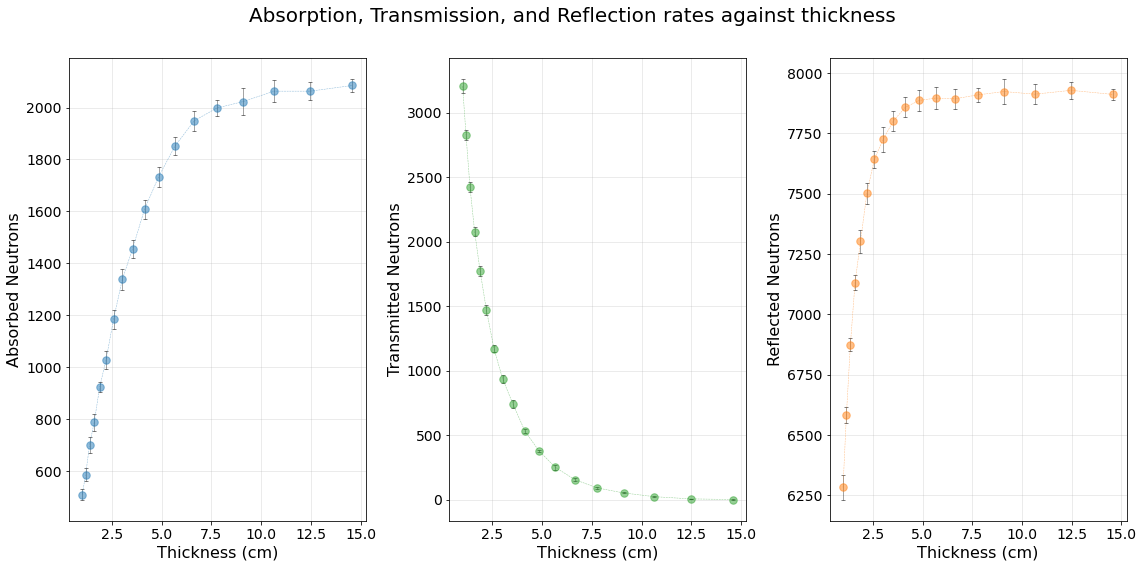

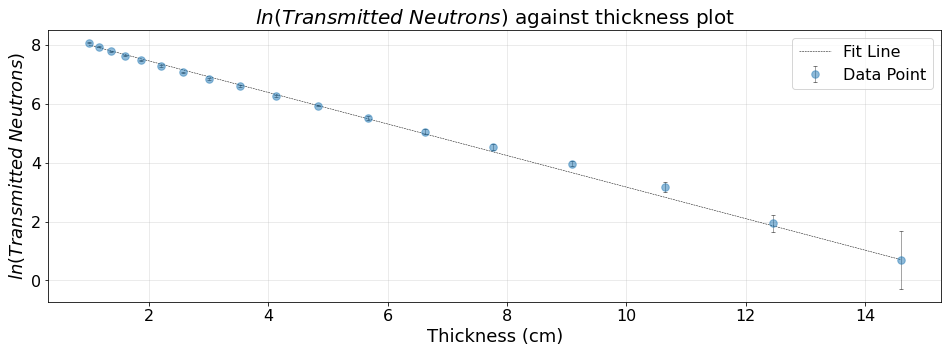

Obtained Attenuation Length: $\lambda = 1.86 ± 0.001$ $cm$

In [70]:
# Varying thickness from 1 to 20 cm logarithmically 

thickness_arr = np.geomspace(1, 20, 20)
calculate_attenuation_and_variation(thickness_arr, mean_free_path_water, prob_A_water)


We can see from the graph that transmission drops exponential with increase in thickness, absorption and back scatter increase and become steady with increase in thickness. This is as expected. 

### 7.2 Attenuation length and variation in rates in lead

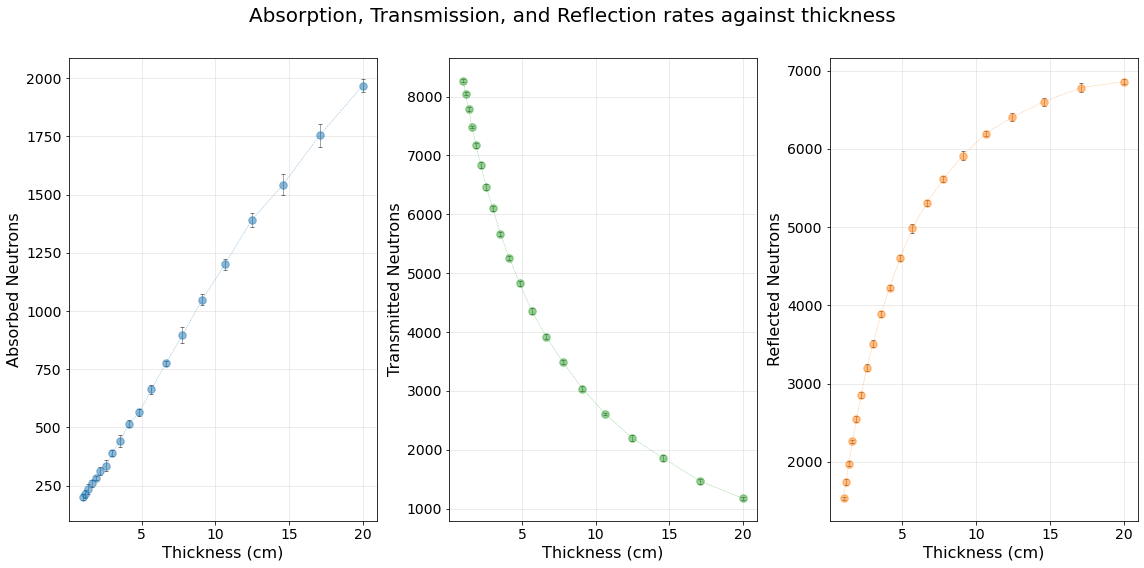

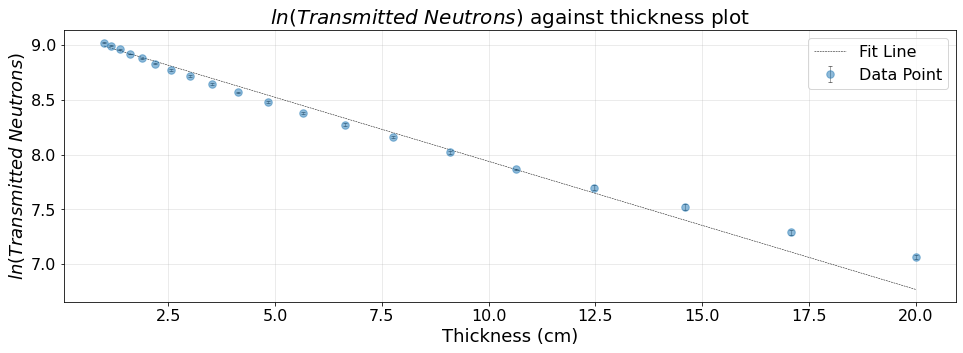

Obtained Attenuation Length: $\lambda = 8.56 ± 0.018$ $cm$

In [71]:
# Varying thickness from 1 to 20 cm logarithmically 

thickness_arr = np.geomspace(1, 20, 20)
calculate_attenuation_and_variation(thickness_arr, mean_free_path_lead, prob_A_lead)


We can see from the graph that transmission drops exponential with increase in thickness, back scatter increases and become steady with increase in thickness, and it is observed that absorption increases steadily for this range.

### 7.3 Attenuation length and variation in rates in graphite

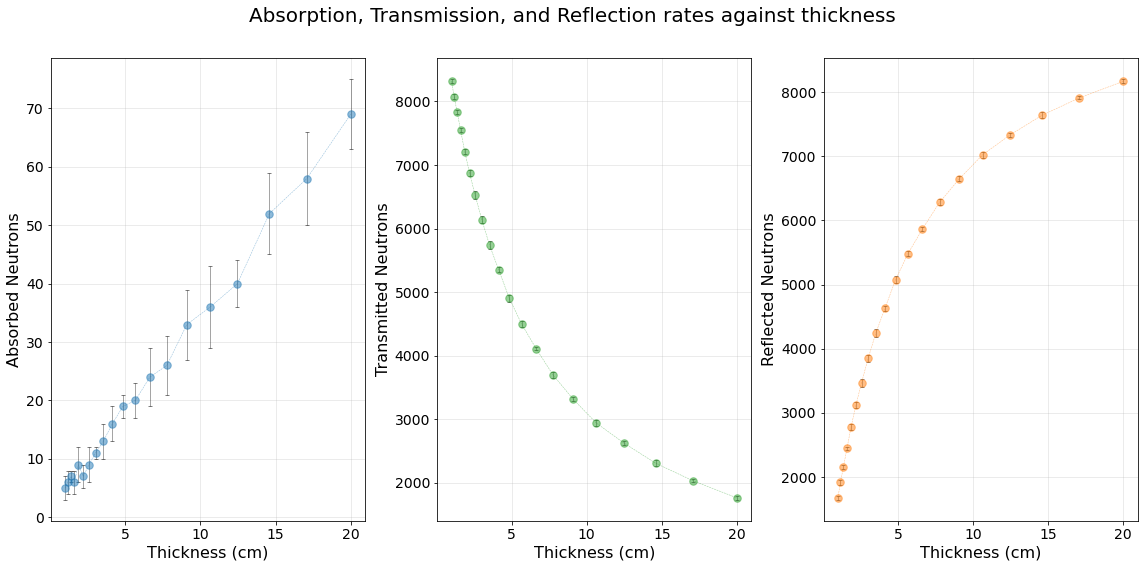

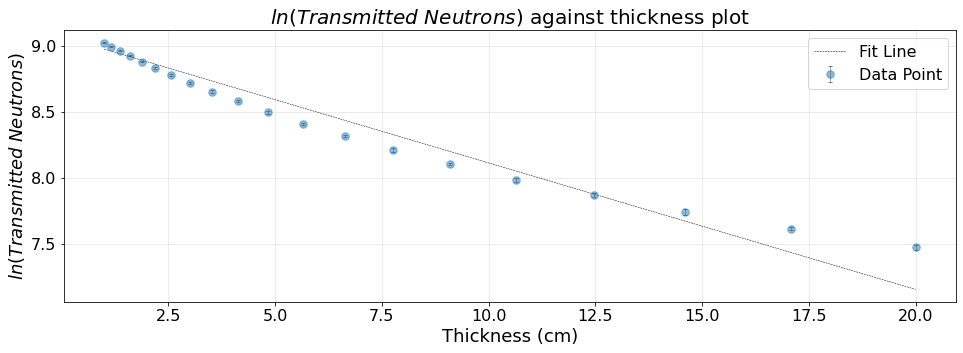

Obtained Attenuation Length: $\lambda = 10.4 ± 0.027$ $cm$

In [72]:
# Varying thickness from 1 to 20 cm logarithmically 

thickness_arr = np.geomspace(1, 20, 20)
calculate_attenuation_and_variation(thickness_arr, mean_free_path_graphite, prob_A_graphite)


We can see from the graph that transmission drops exponential with increase in thickness, back scatter increases and become steady with increase in thickness, and it is observed that absorption varies linearly with thickness.

It is also observed that graphite has the highest attenuation length. Hence, a beam can travel the furthest before its intensity drops be a factor of $1/e$.

## 8. Simulating penetration of neutrons with multiple materials next to each other

In the real world, neutrons go through several materials at the same time. For example in nuclear reactors. To begin simulating this, the procedure is similar to a single material.

A simple approach would be to simulate a neutron in the first material with that material's mean free path and when the neutron enters the second material, switch to the other mean free path. However, when a random walk is occuring in the first material, it is possible that the neutron crosses the boundary using the mean free path of the first material, and thus oversteps.

To prevent this, we use fictitious steps. We select the majorant cross-section as,

$$\Sigma_T = max(\Sigma_1, \Sigma_2, ...)$$

And then a mean free path is,

$$\lambda_T = \frac{1}{\Sigma_T}$$

This is the shortest mean free path out of all the materials. This ensures that the neutron doesn't overstep.

In our simulation, we assume that the materials are placed in the order of decreasing mean free path. To check if a step is fictitious, we can calculate the probability that the step is not fictitious. This is given as,

$$P[\bar{f}] = \frac{\Sigma_1}{\Sigma_T}$$

This is an example for the first material. This is done for all.

If a step is not fictitious, the neutron is either absorbed or scattered in the material it is present in.

This method is known as <b> The Woodcock Method</b>.

The method below simulates fictitious steps.

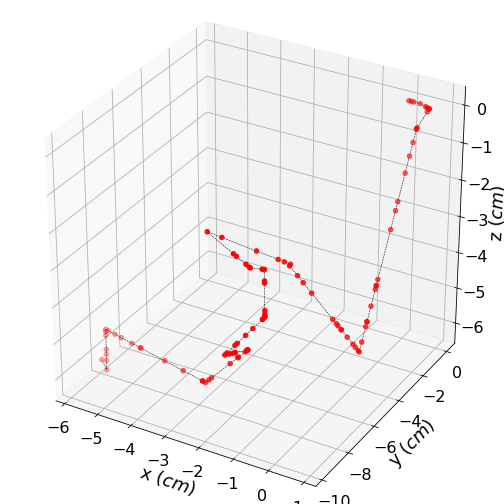

In [78]:
def generate_woodcock_steps(step, mean_free_path, prev_theta=None, prev_phi=None):
    """
    This function generates steps taken by a neutron. The length is drawn from
    the exponential distribution and the vectors are isotropic. All neutrons
    start from (0, 0, 0) and the first step is always in the positive x
    direction. If previous theta and phi values are passed (fictitious step),
    then step is taken according to those angles.
    
    Args:
        step: int
        mean_free_path: float
        prev_theta: float, default: None
        prev_phi: float, default: None
    
    Returns:
        x: float
        y: float
        z: float
        theta: float
        phi: float
    """
    
    x_arr = np.array([])
    y_arr = np.array([])
    z_arr = np.array([])
    theta = 0
    phi = 0
    if step == 0:
        
        # Neutrons starting from (0, 0, 0)
        x = 0
        y = 0
        z = 0
        return x, y, z, theta, phi
    elif step == 1:
        
        # First step only in the positive x direction
        temp = np.random.uniform()
        
        #Length distributed according to the exponential function
        s = np.abs(-mean_free_path*np.log(temp))
        x=s
        y=0
        z=0       
        theta = np.pi/2
        return x, y, z, theta, phi
    else:
        temp = np.random.uniform()
        s = -mean_free_path*np.log(temp)
        if prev_theta == None and prev_phi == None:
            # New angles generated if not fictitious
            u = np.random.uniform()
            theta = np.arccos(1 - 2*u)
            phi = np.random.uniform(high=2*np.pi)
            x = s*np.sin(theta)*np.cos(phi)
            y = s*np.sin(theta)*np.sin(phi)
            z = s*np.cos(theta)
            return x, y, z, theta, phi
        else:
            # Previous angles used if fictitious step
            theta = prev_theta
            phi = prev_phi
            x = s*np.sin(theta)*np.cos(phi)
            y = s*np.sin(theta)*np.sin(phi)
            z = s*np.cos(theta)
            return x, y, z, theta, phi
        

def calc_macro(density, molar_mass, absorption_cross_section, scattering_cross_section):
    """
    This function calculates the macroscopic cross section of a given material using
    the density, molar mass, absorption cross section, and scattering cross section
    of the material.
    
    Args:
        density: float
        molar_mass: float
        absorption_cross_section: float
        scattering_cross_section: float
        
    Returns:
        tot_sigma: float
    """
    #Number of absorbing/scattering molecules
    n = (density * NA) / molar_mass
    
    #Calculating the macroscopic cross sections
    tot_sigmaA = n * absorption_cross_section
    tot_sigmaS = n * scattering_cross_section
    tot_sigma = tot_sigmaA + tot_sigmaS
    
    return tot_sigma
    
def generate_woodcock_neutron_walk(steps, sigma1, sigma2):
    """
    This function simulates a random walk for a given number of steps. This
    is done by iterating the previous vectors with new vectors generated
    using the generate_woodcock_steps() function.
    
    Args:
        steps: int
        sigma1: float
        sigma2: float
        
    Returns:
        x_arr: float array
        y_arr: float array
        z_arr: float array
    """
    # Initializing the parameters
    
    sigmaT = max(sigma1, sigma2)
    sigma_1 = min(sigma1, sigma2)
    prob_notf = sigma_1/sigmaT

    x_arr = np.empty(steps, dtype=float)
    y_arr = np.empty(steps, dtype=float)
    z_arr = np.empty(steps, dtype=float)
    theta_arr = np.empty(steps, dtype=float)
    phi_arr = np.empty(steps, dtype=float)
    mean_free_path = 1/sigmaT * 10**24

    for i in range(steps):
        # Initializing the neutron
        if i == 0:
            x_arr[0], y_arr[0], z_arr[0], theta_arr[0], phi_arr[0] = generate_woodcock_steps(i, mean_free_path)
        elif i == 1:
            x, y, z, theta, phi = generate_woodcock_steps(i, mean_free_path)
            x_arr[i] = x + x_arr[i-1]
            y_arr[i] = y + y_arr[i-1]
            z_arr[i] = z + z_arr[i-1]
            theta_arr[i] = theta
            phi_arr[i] = phi
        else:
            # Adding to the previous step to move the neutron
            v = np.random.uniform()
            
            # Checking if fictitious
            if v >= prob_notf:
            
                x, y, z, theta, phi = generate_woodcock_steps(i, mean_free_path, prev_theta=theta_arr[i-1], prev_phi=phi_arr[i-1])
                x_arr[i] = x + x_arr[i-1]
                y_arr[i] = y + y_arr[i-1]
                z_arr[i] = z + z_arr[i-1]
                theta_arr[i] = theta
                phi_arr[i] = phi
            
            # If not fictitious, neutron moves
            else:
                x, y, z, theta, phi = generate_woodcock_steps(i, mean_free_path)
                x_arr[i] = x + x_arr[i-1]
                y_arr[i] = y + y_arr[i-1]
                z_arr[i] = z + z_arr[i-1]
                theta_arr[i] = theta
                phi_arr[i] = phi
    return x_arr, y_arr, z_arr

# Calculating the macroscopic cross sections
sigma1 = calc_macro(density_water, molar_mass_water, absorption_cross_section_water, scattering_cross_section_water)
sigma2 = calc_macro(density_lead, molar_mass_lead, absorption_cross_section_lead, scattering_cross_section_lead)

# Generating 100 steps

x, y, z = generate_woodcock_neutron_walk(100, sigma1, sigma2)
%matplotlib widget

# Initiliasing a 3D figure
fig = plt.figure(" ", figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.set_box_aspect((1,1,1))
ax.set_position([0, 0, 1, 1])

ax.scatter(x, y, z, color='r')
ax.plot(x, y, z, linestyle='--', color='k', linewidth=0.5)

ax.set_xlabel('x $(cm)$', fontsize=18)
ax.set_ylabel('y $(cm)$', fontsize=18)
ax.set_zlabel('z $(cm)$', fontsize=18)

plt.show()


The above plot shows a neutron taking fictitious steps when the probability is greater than $P[\bar{f}]$ and thus preserving the angles. When this isn't true, the neutron changes direction.

Now we simulate multiple materials. The code is implemented below.

## 8.1 The Woodcock Method

The code below simulates multiple materials next to each other using the parameters stated before. This can be done for multiple materials. Instead of simulating one neutron at a time which will be very computationaly taxing, we will again bulk simulate multiple neutrons in parallel. This is done below.

In [74]:
def bulk_move(i, n, mean_free_path, x_arr=np.empty((0, 4))):
    """
    This function moves n neutrons simultaenously. The function
    either moves the neutrons fictitiously or normally depending
    on the conditions. Since only x direction movement is
    required, the function only moves the neutrons in x direction.
    However, previous angles are used in case of fictitious steps.
    
    Args:
        i: int
        n: int
        mean_free_path: float
        x_arr: 2D float array, default: empty array 

    Returns:
        x_arr: 2D float array
    """   
    # Creating an empty array with 4 columns if none given
    
    # x_arr consists of 4 columns: x position, if fictitious step
    # needed boolean, theta, phi
    if len(x_arr) == 0:
        x_arr = np.empty((n, 4), dtype=float)
        
    if i == 0:
        # Generating n initial values of x=0
        x_arr[:, 0] = np.repeat(0, n)
        x_arr[:, 1] = np.repeat(False, n)
        x_arr[:, 2] = np.repeat(0, n)
        x_arr[:, 3] = np.repeat(0, n)
    elif i == 1:
        # First step is always in the positive x direction
        deltaX_arr = np.abs(-mean_free_path * np.log(np.random.uniform(size=n)))
        x_arr[:, 0] += deltaX_arr
        x_arr[:, 1] = np.repeat(False, n)
        x_arr[:, 2] = np.repeat(np.pi/2, n)
        x_arr[:, 3] = np.repeat(0, n)
    else:
        # Subsequent steps are isotropic. x values for n neutrons are generated
        s = -mean_free_path * np.log(np.random.uniform(size=n))
        
        # Array of phi and theta generated.
        # If fictious boolean is true (2nd column), angles obtained from the given
        # x_arr and phi and theta values in the arrays are updated with the previous
        # values
        phi = np.random.uniform(high=2*np.pi, size=n) 
        
        # The check is done here, if fictitious = True, previous values of angles used
        phi[np.argwhere(x_arr[:, 1] == 1)] = x_arr[np.argwhere(x_arr[:, 1] == 1), 3]
        theta = np.arccos(1 - (2 * np.random.uniform(size=n)))
        theta[np.argwhere(x_arr[:, 1] == 1)] = x_arr[np.argwhere(x_arr[:, 1] == 1), 2]
        deltaX_arr = s*np.sin(theta)*np.cos(phi)
        
        # x position moved
        x_arr[:, 0] += deltaX_arr
        
        # Sets the theta and phi values to the array
        x_arr[:, 2] = theta
        x_arr[:, 3] = phi
    
    return x_arr

def bulk_generate_probabilities(n):
    """
    This function generates n random values corresponding to n neutrons.
    This is then compared to absorption probability to determine if
    neutron is absorbed or scattered.
    
    Args:
        n: int
        
    Returns:
        probs: float array of size n
    """
    # Generating random number between 0 and 1, uniformly distributed
    probs = np.random.uniform(size=n)        
    return probs

def simulate_neutrons_woodcock(n, material_data_arr):
    """
    This function simulates n neutrons through multiple materials simultaneously 
    using the woodcock method. Each neutron's random walk is independent of the 
    other. This bulk simulation is accompalished using numpy arrays. The function 
    then returns the number of absorbed, transmitted, and reflected neutrons.
    
    Args:
        n: int
        material_data_arr: 2D float array
    
    Returns:
        absorbed: int
        transmitted: int
        reflected: int
    """
    # Initiliazing some parameters
    
    # Material data array consists of macroscopic cross sections,
    # absorption probabilities, and slab thickness. This is sorted
    # according to the macroscopic cross section sigma.
    material_data_arr = material_data_arr[material_data_arr[:, 0].argsort()]
 
    # The arrays are then separated
    sigma_arr = material_data_arr[:, 0]
    abs_prob_arr = material_data_arr[:, 1]
    thickness_arr = material_data_arr[:, 2]
    
    total_thickness = sum(thickness_arr)
    total_cross_section = max(sigma_arr)
    
    # P(not fictitious) calculated for each material
    not_fict_prob_arr = sigma_arr/total_cross_section
    mean_free_path = 1/total_cross_section * 10**24    
    
    # Initializing the neutrons
    x = bulk_move(0, n, mean_free_path)
    
    # Step number
    step = 1
    absorbed = 0
    reflected = 0
    transmitted = 0
      
    # The loop runs till there are no neutrons left
    while len(x) > 0:
        
        # Neutrons that have x < 0 are considered reflected
        
        reflected += len(np.argwhere(x[:, 0] < 0))
        
        # Neutrons above x > thickness are considered transmitted
        transmitted += len(np.argwhere(x[:, 0] > total_thickness))

        # The reflected and transmitted neutrons are then deleted from the array of neutrons
        x = np.delete(x, np.argwhere(x[:, 0] < 0), axis=0)
        x = np.delete(x, np.argwhere(x[:, 0] > total_thickness), axis=0)


        # A new length of the array is determined to generate probabilities
        gen_n = len(x)
        
        # Probabilities to check if fictitious step required associated with each neutron are generated
        fict_probs = bulk_generate_probabilities(gen_n)
        
        for i in range(len(thickness_arr)):
            if i==0:
                # Sets fictitious to true if generated prob > P(not fict)
                # otherwise sets that data point to false. This is for 
                # first material
                x[np.argwhere((0 <= x[:, 0]) & (x[:, 0] <= thickness_arr[i]) & 
                              (fict_probs >=not_fict_prob_arr[i])), 1] = True
                x[np.argwhere((0 <= x[:, 0]) & (x[:, 0] <= thickness_arr[i]) & 
                              (fict_probs < not_fict_prob_arr[i])), 1] = False
            else:
                # The same is repeated for the other materials
                x[np.argwhere((thickness_arr[i-1] < x[:, 0]) & (x[:, 0] <= sum(thickness_arr[:i+1])) & 
                              (fict_probs >= not_fict_prob_arr[i])), 1] = True
                x[np.argwhere((thickness_arr[i-1] < x[:, 0]) & (x[:, 0] <= sum(thickness_arr[:i+1])) & 
                              (fict_probs < not_fict_prob_arr[i])), 1] = False
        
        #Checking if absorbed or not
        
        for i in range(len(thickness_arr)):
            # A new length is generated
            gen_n = len(x)
            
            # Generating another set of probabilities
            probs = bulk_generate_probabilities(gen_n)
            if i==0:
                # Neutrons with probabilities lower than absorption probability are considered absorbed
                # and deleted from the array of neutrons.
                absorbed += len(np.argwhere((0 <= x[:, 0]) & (x[:, 0] <= thickness_arr[i]) & (x[:, 1] == 0) & 
                                            (probs <= abs_prob_arr[i])))
                x = np.delete(x, np.argwhere((0 <= x[:, 0]) & (x[:, 0] <= thickness_arr[i]) & (x[:, 1] == 0) &
                                             (probs <= abs_prob_arr[i])), axis=0)
            else:
                absorbed += len(np.argwhere((thickness_arr[i-1] < x[:, 0]) & (x[:, 0] <= sum(thickness_arr[:i+1])) & 
                                            (x[:, 1] == 0) & (probs <= abs_prob_arr[i])))
                x = np.delete(x, np.argwhere((thickness_arr[i-1] < x[:, 0]) & (x[:, 0] <= sum(thickness_arr[:i+1])) & 
                                             (x[:, 1] == 0) & (probs <= abs_prob_arr[i])), axis=0)
                
        # A new size is determined for the array, and the left over neutrons are moved by another step
        new_size = len(x)
        x = bulk_move(step, new_size, mean_free_path, x)
        step += 1
    
    return absorbed, transmitted, reflected
    

def simulate_neutrons_with_errors(title, N, material_data_arr, iterations):
    """
    This function runs the Woodcock neutron simulation 'iterations' number of times
    to produce an error on the absorbed, transmitted, and reflected values. Each
    simulation consists of N neutrons being simulated. The obtained value are 
    then printed.
    
    Args:
        title: str
        N: int
        material_data_arr: 2D float array
        iterations: int
        
    Returns:
        None
    """
    # Initializing
    absorbed_arr = np.empty(iterations, dtype=float)
    transmitted_arr = np.empty(iterations, dtype=float)
    reflected_arr = np.empty(iterations, dtype=float)
    
    for i in range(iterations):
        absorbed_arr[i], transmitted_arr[i], reflected_arr[i] = simulate_neutrons_woodcock(N, material_data_arr)
    
    # Removing nan's if they occur
    absorbed_arr = absorbed_arr[np.logical_not(np.isnan(absorbed_arr))]
    transmitted_arr = transmitted_arr[np.logical_not(np.isnan(transmitted_arr))]
    reflected_arr = reflected_arr[np.logical_not(np.isnan(reflected_arr))]
    
    # The mean of the values taken, error taken as standard deviation
    final_absorbed_data = np.array([np.average(absorbed_arr), np.std(absorbed_arr)])
    final_transmitted_data = np.array([np.average(transmitted_arr), np.std(transmitted_arr)])
    final_reflected_data = np.array([np.average(reflected_arr), np.std(reflected_arr)])
    
    # Printing the data
    print('----------------------------------')
    print(title)
    print('----------------------------------')
    print("Total number of Neutrons: {0}".format(N))
    print("Percentage of Neutrons Absorbed: {0:.3g}% ± {1:.3f}".format((final_absorbed_data[0] * 100/N), 
                                                final_absorbed_data[1]/final_absorbed_data[0]))
    print("Percentage of Neutrons Transmitted: {0:.3g}% ± {1:.3f}%".format((final_transmitted_data[0] * 100/N), 
                                                final_transmitted_data[1]/final_transmitted_data[0]))
    print("Percentage of Neutrons Reflected: {0:.3g}% ± {1:.3f}%".format((final_reflected_data[0] * 100/N), 
                                                final_reflected_data[1]/final_reflected_data[0]))


## 8.2 Two Materials together: Graphite/Water

Below is the simulation of graphite and water together. Water is kept as the second material as it has the lower mean free path of the two. This is implemented below. 10000 Neutrons are simulated and each simulation is done 10 times to obtain errors.

In [75]:
# Graphite-Water 10cm thickness each

sigma_graphite = calc_macro(density_graphite, molar_mass_graphite, absorption_cross_section_graphite, 
                    scattering_cross_section_graphite)
sigma_water = calc_macro(density_water, molar_mass_water, absorption_cross_section_water, scattering_cross_section_water)

sigma_arr = [sigma_graphite, sigma_water]
absorption_prob_arr = [prob_A_graphite, prob_A_water]
thickness_arr = [10, 10] # in cm

material_data_arr = np.empty((len(thickness_arr), 3))

material_data_arr[:, 0] = sigma_arr
material_data_arr[:, 1] = absorption_prob_arr
material_data_arr[:, 2] = thickness_arr

N = 10000
number_of_simulations = 10

title = "10cm slabs of graphite and water next to each other"
simulate_neutrons_with_errors(title, N, material_data_arr, number_of_simulations)


----------------------------------
10cm slabs of graphite and water next to each other
----------------------------------
Total number of Neutrons: 10000
Percentage of Neutrons Absorbed: 14.1% ± 0.020
Percentage of Neutrons Transmitted: 0.209% ± 0.185%
Percentage of Neutrons Reflected: 85.7% ± 0.004%


## 8.3 Verifying the Woodcock Method

We can verify the method by taking the first slab as vacuum. Vacuum has an absorption cross section of 0 and absorption probability of 0. The results should be the same as a singular material random walk. This is implemented below for Vacuum-Water interface below.

In [76]:
# Vacuum-Water 10cm thickness each

sigma_water = calc_macro(density_water, molar_mass_water, absorption_cross_section_water, scattering_cross_section_water)

sigma_arr = [0, sigma_water]
absorption_prob_arr = [0, prob_A_water]
thickness_arr = [10, 10] # in cm

material_data_arr = np.empty((len(thickness_arr), 3))

material_data_arr[:, 0] = sigma_arr
material_data_arr[:, 1] = absorption_prob_arr
material_data_arr[:, 2] = thickness_arr

N = 10000
number_of_simulations = 10

title = "10cm slabs of vacuum and water next to each other"
simulate_neutrons_with_errors(title, N, material_data_arr, number_of_simulations)


----------------------------------
10cm slabs of vacuum and water next to each other
----------------------------------
Total number of Neutrons: 10000
Percentage of Neutrons Absorbed: 20% ± 0.017
Percentage of Neutrons Transmitted: 0.326% ± 0.207%
Percentage of Neutrons Reflected: 79.7% ± 0.004%


Hence it can be seen that the rates of absorption, transmission, and reflection are as expected. Hence Woodcock method works.

We can now simulate three materials.

## 8.4 Three Materials together: Lead, Graphite, and Water

Below is the implementation of 10cm slabs of lead, graphite, and water.

In [77]:
# Lead-Graphite-Water 10cm thickness each

sigma_graphite = calc_macro(density_graphite, molar_mass_graphite, absorption_cross_section_graphite, 
                    scattering_cross_section_graphite)
sigma_water = calc_macro(density_water, molar_mass_water, absorption_cross_section_water, scattering_cross_section_water)
sigma_lead = calc_macro(density_lead, molar_mass_lead, absorption_cross_section_lead, scattering_cross_section_lead)

sigma_arr = [sigma_lead, sigma_graphite, sigma_water]
# Reusing values from previous calculations
absorption_prob_arr = [prob_A_lead, prob_A_graphite, prob_A_water]
thickness_arr = [10, 10, 10] # in cm

material_data_arr = np.empty((len(thickness_arr), 3))

material_data_arr[:, 0] = sigma_arr
material_data_arr[:, 1] = absorption_prob_arr
material_data_arr[:, 2] = thickness_arr

N = 10000
number_of_simulations = 10

title = "10cm slabs of lead, graphite, and water next to each other"
simulate_neutrons_with_errors(title, N, material_data_arr, number_of_simulations)


----------------------------------
10cm slabs of lead, graphite, and water next to each other
----------------------------------
Total number of Neutrons: 10000
Percentage of Neutrons Absorbed: 26.7% ± 0.012
Percentage of Neutrons Transmitted: 0.002% ± 2.000%
Percentage of Neutrons Reflected: 73.3% ± 0.004%


This code can easily be extended to multiple materials by getting their macroscopic cross sections and passing it to the simulation.